# 생체인증보안 1871085 지문 1차 답안

In [1]:
# 라이브러리 import
import PIL.Image as pilimg
import numpy as np
import glob
import matplotlib.pyplot as plt
import re

In [55]:
# 이미지 목록
images = glob.glob('./01_finger_training/*.bmp')
len(images)

80

In [3]:
r = re.compile('\d+')

img = [] # 이미지
label = [] # 라벨

for fname in images:
    l = r.findall(fname)[1]
    if l == '8': # 처리 편의성을 위해 라벨 범위를 1-8에서 0-7로 변경
        l = '0'
    label.append(l)
    im = pilimg.open(fname)
    pix = np.array(im)[25:120,25:120]/255. # 검은 부분 제거, Normalize
    img.append(pix)

In [4]:
X = np.array(img)
X = X.reshape(X.shape[0],95,95,1)
X.shape # img shape

(80, 95, 95, 1)

In [5]:
y = np.array(label, dtype='int32')
y # label

array([7, 4, 6, 4, 6, 3, 7, 1, 7, 3, 3, 0, 1, 4, 4, 7, 6, 7, 1, 6, 5, 4,
       1, 1, 2, 1, 5, 3, 0, 4, 6, 4, 5, 5, 2, 3, 7, 1, 2, 3, 2, 1, 5, 3,
       7, 2, 6, 0, 4, 5, 0, 3, 1, 0, 0, 3, 6, 0, 5, 6, 5, 2, 4, 0, 0, 2,
       2, 0, 6, 3, 7, 1, 7, 5, 5, 2, 4, 2, 7, 6], dtype=int32)

(95, 95, 1)
7


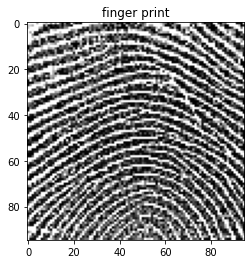

In [6]:
# 지문 이미지
plt.title('finger print')
plt.imshow(X[0], cmap='gray')
print(X[0].shape)
print(y[0])

In [7]:
X.shape

(80, 95, 95, 1)

## PCA로 데이터 분포 확인

In [8]:
from sklearn.decomposition import PCA
X_ = X.reshape(80,9025)
pca_X = PCA(2)
X_data_proj = pca_X.fit_transform(X_)

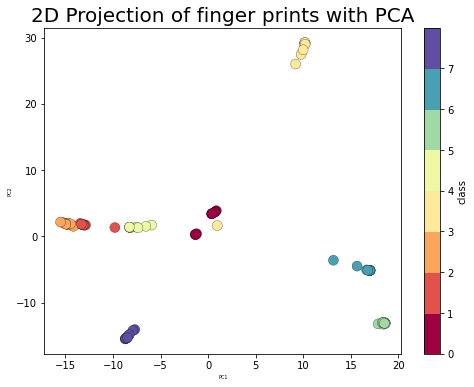

In [9]:
plt.figure(num='', figsize=(8,6))
plt.scatter(X_data_proj[:,0], X_data_proj[:,1], lw=0.25, c=y, edgecolor='k', s=100,
           cmap=plt.cm.get_cmap('Spectral',8))
plt.xlabel('PC1', size=5)
plt.ylabel('PC2', size=5)
plt.title('2D Projection of finger prints with PCA', size=20)
plt.colorbar(ticks=range(8), label='class')
plt.clim(0, 8)
plt.show()

## Data Augmentation

In [10]:
# !pip install imgaug

In [11]:
from imgaug import augmenters as iaa

In [12]:
seq = iaa.Sequential([
    # blur images with a sigma of 0 to 0.1
    iaa.GaussianBlur(sigma=(0, 0.1)),
    iaa.Affine(
        # scale images to 90-110% of their size, individually per axis
        #scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
        # translate by -10 to +10 percent (per axis)
        translate_percent={"x": (-0.01, 0.01), "y": (-0.01, 0.01)},
        # rotate by -5 to +5 degrees
        #rotate=(-5, 5),
        # use nearest neighbour or bilinear interpolation (fast)
        order=[0, 1],
        # if mode is constant, use a cval between 0 and 255
        cval=0
    )
], random_order=True)

def aug_data(X_data, y_data):
    augmentated_data = [] # 생성한 이미지
    augmentated_label = [] # 생성한 이미지의 라벨
    for i in range(len(X)):
        augs = [X[i]] * 9 # 이미지당 9개 추가 생성
        augs = seq.augment_images(augs)
        for aug in augs:
            augmentated_data.append(aug)
            augmentated_label.append(y_data[i])
    
    return augmentated_data, augmentated_label

In [13]:
x_d, y_d = aug_data(X, y) # 이미지 생성

In [14]:
print(len(x_d), len(y_d))

720 720


(95, 95, 1)
7


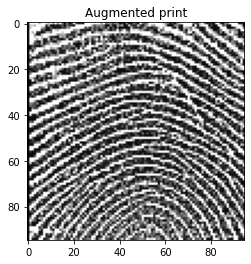

In [15]:
# 생성한 지문 이미지
plt.title('Augmented print')
plt.imshow(x_d[0], cmap='gray')
print(x_d[0].shape)
print(y_d[0])

In [16]:
# 생성한 이미지
x_d = np.array(x_d)
y_d = np.array(y_d)
print(x_d.shape)
print(y_d.shape)

(720, 95, 95, 1)
(720,)


In [17]:
# 기존 이미지
print(X.shape)
print(y.shape)

(80, 95, 95, 1)
(80,)


In [18]:
# 기존 이미지, 생성 이미지 합치기
X_data = np.concatenate([X, x_d], axis=0)
y_data = np.concatenate([y, y_d], axis=0)
print(X_data.shape)
print(y_data.shape)

(800, 95, 95, 1)
(800,)


# Augmentation 후 데이터 분포 확인

In [19]:
from sklearn.decomposition import PCA
X_d_ = X_data.reshape(800,9025)
pca_X = PCA(2)
X_d_proj = pca_X.fit_transform(X_d_)

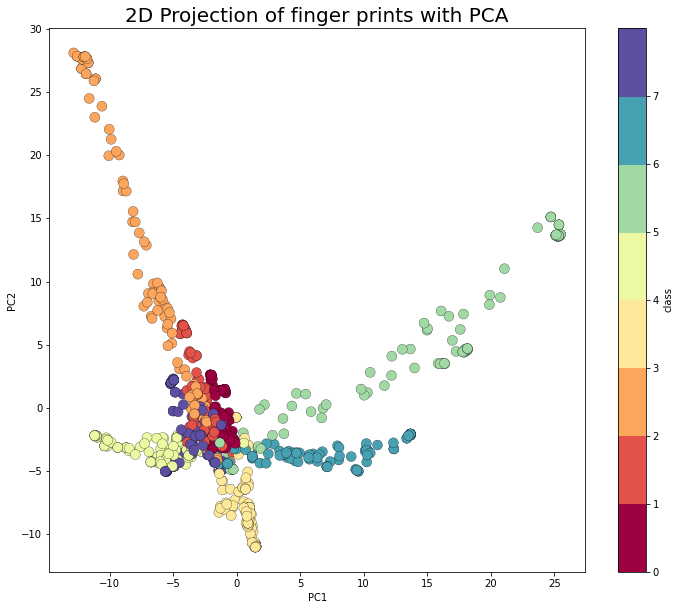

In [20]:
plt.figure(num='', figsize=(12,10))
plt.scatter(X_d_proj[:,0], X_d_proj[:,1], lw=0.25, c=y_data, edgecolor='k', s=100,
           cmap=plt.cm.get_cmap('Spectral',8))
plt.xlabel('PC1', size=10)
plt.ylabel('PC2', size=10)
plt.title('2D Projection of finger prints with PCA', size=20)
plt.colorbar(ticks=range(8), label='class')
plt.clim(0, 8)
plt.show()

# Data split

In [29]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_data,y_data, test_size=0.2, shuffle=True, stratify=y_data, random_state=101)

In [30]:
X_train=X_train.astype('float32')
y_train=y_train.astype('int32')
X_test=X_test.astype('float32')
y_test=y_test.astype('int32')

In [31]:
X_train = X_train.reshape(X_train.shape[0],95,95,1)
X_test = X_test.reshape(X_test.shape[0],95,95,1)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(640, 95, 95, 1) (640,) (160, 95, 95, 1) (160,)


In [32]:
# Input shape
X_train[0].shape

(95, 95, 1)

# Model

In [33]:
import xgboost as xgb
from xgboost import plot_importance
from xgboost import XGBClassifier
from sklearn.metrics import mean_squared_error

In [34]:
# shape 변환
X_train_2dim = X_train.reshape(X_train.shape[0], 9025)
X_test_2dim = X_test.reshape(X_test.shape[0], 9025)

In [35]:
model = xgb.XGBClassifier(learning_rate = 0.001, max_depth = 4, n_estimators = 4000)

In [36]:
# Cross validation
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
all_history = [] # 결과 저장

def score_model(model, cv=None):
    if cv is None:
        cv = StratifiedKFold(n_splits=4, random_state=42, shuffle=True)
        
    i=0
    for train_fold_index, val_fold_index in cv.split(X_train_2dim, y_train):
        i=i+1
        print('Fold #',i)
        # Get the training data
        X_train_fold, y_train_fold = X_train[train_fold_index], y_train[train_fold_index]
        # Get the validation data
        X_val_fold, y_val_fold = X_train[val_fold_index], y_train[val_fold_index]
        
        x,y,z,w = X_train_fold.shape
        print(y_val_fold)
        X_train_reshaped = X_train_fold.reshape(X_train_fold.shape[0], 9025)
        X_val_reshaped = X_val_fold.reshape(X_val_fold.shape[0], 9025)
        
        print(X_val_reshaped.shape)
        print(y_val_fold.shape)
        
        # Fit the model
        evals = [(X_train_reshaped, y_train_fold), (X_val_reshaped, y_val_fold)]
        model_obj = model.fit(X_train_reshaped, y_train_fold,
                              eval_metric=["mlogloss"], 
                              eval_set=evals, 
                              verbose=1)
        all_history.append(model.evals_result())

# Example of the model in action
score_model(model, cv=skf)

Fold # 1
[1 7 0 2 0 2 5 6 0 0 6 0 3 7 2 3 1 5 5 3 1 7 3 6 2 5 2 5 4 1 6 4 1 7 2 2 6
 5 7 5 0 0 4 2 3 4 7 3 3 7 3 5 1 4 4 3 4 0 7 3 7 2 0 1 6 6 7 5 7 7 7 6 0 3
 3 1 6 4 7 0 2 2 6 5 0 0 2 5 6 1 0 4 7 4 6 0 4 2 1 2 1 7 4 4 1 5 4 2 2 6 3
 4 0 1 5 3 5 5 1 1 1 2 7 3 6 0 1 2 5 1 3 3 3 4 3 2 7 0 5 3 4 0 7 1 2 5 7 5
 1 6 6 6 4 6 5 0 4 6 6 4]
(160, 9025)
(160,)


/home/yeon_28/anaconda3/envs/dl/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-mlogloss:2.07600	validation_1-mlogloss:2.07634
[1]	validation_0-mlogloss:2.07257	validation_1-mlogloss:2.07328
[2]	validation_0-mlogloss:2.06915	validation_1-mlogloss:2.07020
[3]	validation_0-mlogloss:2.06575	validation_1-mlogloss:2.06716
[4]	validation_0-mlogloss:2.06235	validation_1-mlogloss:2.06414
[5]	validation_0-mlogloss:2.05897	validation_1-mlogloss:2.06111
[6]	validation_0-mlogloss:2.05559	validation_1-mlogloss:2.05809
[7]	validation_0-mlogloss:2.05223	validation_1-mlogloss:2.05505
[8]	validation_0-mlogloss:2.04888	validation_1-mlogloss:2.05207
[9]	validation_0-mlogloss:2.04554	validation_1-mlogloss:2.04907
[10]	validation_0-mlogloss:2.04221	validation_1-mlogloss:2.04611
[11]	validation_0-mlogloss:2.03889	validation_1-mlogloss:2.04313
[12]	validation_0-mlogloss:2.03558	validation_1-mlogloss:2.04017
[13]	validation_0-mlogloss:2.03228	validation_1-mlogloss:2.03722
[14]	validation_0-mlogloss:2.02899	validation_1-mlogloss:2.03426
[15]	validation_0-mlogloss:2.02571	

[126]	validation_0-mlogloss:1.71355	validation_1-mlogloss:1.75014
[127]	validation_0-mlogloss:1.71112	validation_1-mlogloss:1.74792
[128]	validation_0-mlogloss:1.70870	validation_1-mlogloss:1.74571
[129]	validation_0-mlogloss:1.70629	validation_1-mlogloss:1.74350
[130]	validation_0-mlogloss:1.70388	validation_1-mlogloss:1.74130
[131]	validation_0-mlogloss:1.70148	validation_1-mlogloss:1.73909
[132]	validation_0-mlogloss:1.69908	validation_1-mlogloss:1.73690
[133]	validation_0-mlogloss:1.69669	validation_1-mlogloss:1.73470
[134]	validation_0-mlogloss:1.69430	validation_1-mlogloss:1.73252
[135]	validation_0-mlogloss:1.69192	validation_1-mlogloss:1.73034
[136]	validation_0-mlogloss:1.68955	validation_1-mlogloss:1.72816
[137]	validation_0-mlogloss:1.68718	validation_1-mlogloss:1.72600
[138]	validation_0-mlogloss:1.68482	validation_1-mlogloss:1.72383
[139]	validation_0-mlogloss:1.68247	validation_1-mlogloss:1.72165
[140]	validation_0-mlogloss:1.68012	validation_1-mlogloss:1.71954
[141]	vali

[251]	validation_0-mlogloss:1.44845	validation_1-mlogloss:1.50824
[252]	validation_0-mlogloss:1.44658	validation_1-mlogloss:1.50653
[253]	validation_0-mlogloss:1.44472	validation_1-mlogloss:1.50482
[254]	validation_0-mlogloss:1.44286	validation_1-mlogloss:1.50315
[255]	validation_0-mlogloss:1.44101	validation_1-mlogloss:1.50145
[256]	validation_0-mlogloss:1.43915	validation_1-mlogloss:1.49976
[257]	validation_0-mlogloss:1.43731	validation_1-mlogloss:1.49805
[258]	validation_0-mlogloss:1.43546	validation_1-mlogloss:1.49637
[259]	validation_0-mlogloss:1.43362	validation_1-mlogloss:1.49470
[260]	validation_0-mlogloss:1.43179	validation_1-mlogloss:1.49302
[261]	validation_0-mlogloss:1.42995	validation_1-mlogloss:1.49132
[262]	validation_0-mlogloss:1.42813	validation_1-mlogloss:1.48968
[263]	validation_0-mlogloss:1.42630	validation_1-mlogloss:1.48802
[264]	validation_0-mlogloss:1.42448	validation_1-mlogloss:1.48635
[265]	validation_0-mlogloss:1.42266	validation_1-mlogloss:1.48470
[266]	vali

[376]	validation_0-mlogloss:1.23918	validation_1-mlogloss:1.31446
[377]	validation_0-mlogloss:1.23769	validation_1-mlogloss:1.31307
[378]	validation_0-mlogloss:1.23620	validation_1-mlogloss:1.31169
[379]	validation_0-mlogloss:1.23471	validation_1-mlogloss:1.31028
[380]	validation_0-mlogloss:1.23322	validation_1-mlogloss:1.30890
[381]	validation_0-mlogloss:1.23174	validation_1-mlogloss:1.30750
[382]	validation_0-mlogloss:1.23026	validation_1-mlogloss:1.30610
[383]	validation_0-mlogloss:1.22878	validation_1-mlogloss:1.30471
[384]	validation_0-mlogloss:1.22730	validation_1-mlogloss:1.30332
[385]	validation_0-mlogloss:1.22583	validation_1-mlogloss:1.30193
[386]	validation_0-mlogloss:1.22435	validation_1-mlogloss:1.30055
[387]	validation_0-mlogloss:1.22288	validation_1-mlogloss:1.29917
[388]	validation_0-mlogloss:1.22142	validation_1-mlogloss:1.29780
[389]	validation_0-mlogloss:1.21995	validation_1-mlogloss:1.29643
[390]	validation_0-mlogloss:1.21849	validation_1-mlogloss:1.29505
[391]	vali

[501]	validation_0-mlogloss:1.07028	validation_1-mlogloss:1.15543
[502]	validation_0-mlogloss:1.06906	validation_1-mlogloss:1.15427
[503]	validation_0-mlogloss:1.06784	validation_1-mlogloss:1.15312
[504]	validation_0-mlogloss:1.06663	validation_1-mlogloss:1.15198
[505]	validation_0-mlogloss:1.06541	validation_1-mlogloss:1.15084
[506]	validation_0-mlogloss:1.06420	validation_1-mlogloss:1.14970
[507]	validation_0-mlogloss:1.06299	validation_1-mlogloss:1.14855
[508]	validation_0-mlogloss:1.06178	validation_1-mlogloss:1.14740
[509]	validation_0-mlogloss:1.06057	validation_1-mlogloss:1.14625
[510]	validation_0-mlogloss:1.05936	validation_1-mlogloss:1.14510
[511]	validation_0-mlogloss:1.05816	validation_1-mlogloss:1.14396
[512]	validation_0-mlogloss:1.05696	validation_1-mlogloss:1.14282
[513]	validation_0-mlogloss:1.05575	validation_1-mlogloss:1.14169
[514]	validation_0-mlogloss:1.05455	validation_1-mlogloss:1.14055
[515]	validation_0-mlogloss:1.05336	validation_1-mlogloss:1.13941
[516]	vali

[626]	validation_0-mlogloss:0.93079	validation_1-mlogloss:1.02354
[627]	validation_0-mlogloss:0.92977	validation_1-mlogloss:1.02257
[628]	validation_0-mlogloss:0.92875	validation_1-mlogloss:1.02161
[629]	validation_0-mlogloss:0.92773	validation_1-mlogloss:1.02065
[630]	validation_0-mlogloss:0.92672	validation_1-mlogloss:1.01969
[631]	validation_0-mlogloss:0.92570	validation_1-mlogloss:1.01874
[632]	validation_0-mlogloss:0.92469	validation_1-mlogloss:1.01779
[633]	validation_0-mlogloss:0.92368	validation_1-mlogloss:1.01684
[634]	validation_0-mlogloss:0.92267	validation_1-mlogloss:1.01589
[635]	validation_0-mlogloss:0.92166	validation_1-mlogloss:1.01493
[636]	validation_0-mlogloss:0.92065	validation_1-mlogloss:1.01398
[637]	validation_0-mlogloss:0.91965	validation_1-mlogloss:1.01302
[638]	validation_0-mlogloss:0.91864	validation_1-mlogloss:1.01206
[639]	validation_0-mlogloss:0.91764	validation_1-mlogloss:1.01111
[640]	validation_0-mlogloss:0.91664	validation_1-mlogloss:1.01019
[641]	vali

[751]	validation_0-mlogloss:0.81327	validation_1-mlogloss:0.91233
[752]	validation_0-mlogloss:0.81240	validation_1-mlogloss:0.91150
[753]	validation_0-mlogloss:0.81154	validation_1-mlogloss:0.91066
[754]	validation_0-mlogloss:0.81067	validation_1-mlogloss:0.90984
[755]	validation_0-mlogloss:0.80981	validation_1-mlogloss:0.90902
[756]	validation_0-mlogloss:0.80895	validation_1-mlogloss:0.90818
[757]	validation_0-mlogloss:0.80809	validation_1-mlogloss:0.90737
[758]	validation_0-mlogloss:0.80723	validation_1-mlogloss:0.90654
[759]	validation_0-mlogloss:0.80637	validation_1-mlogloss:0.90572
[760]	validation_0-mlogloss:0.80551	validation_1-mlogloss:0.90490
[761]	validation_0-mlogloss:0.80465	validation_1-mlogloss:0.90408
[762]	validation_0-mlogloss:0.80380	validation_1-mlogloss:0.90325
[763]	validation_0-mlogloss:0.80294	validation_1-mlogloss:0.90243
[764]	validation_0-mlogloss:0.80209	validation_1-mlogloss:0.90161
[765]	validation_0-mlogloss:0.80123	validation_1-mlogloss:0.90079
[766]	vali

[876]	validation_0-mlogloss:0.71289	validation_1-mlogloss:0.81536
[877]	validation_0-mlogloss:0.71214	validation_1-mlogloss:0.81463
[878]	validation_0-mlogloss:0.71140	validation_1-mlogloss:0.81391
[879]	validation_0-mlogloss:0.71066	validation_1-mlogloss:0.81318
[880]	validation_0-mlogloss:0.70992	validation_1-mlogloss:0.81246
[881]	validation_0-mlogloss:0.70918	validation_1-mlogloss:0.81174
[882]	validation_0-mlogloss:0.70844	validation_1-mlogloss:0.81101
[883]	validation_0-mlogloss:0.70771	validation_1-mlogloss:0.81030
[884]	validation_0-mlogloss:0.70697	validation_1-mlogloss:0.80958
[885]	validation_0-mlogloss:0.70623	validation_1-mlogloss:0.80886
[886]	validation_0-mlogloss:0.70550	validation_1-mlogloss:0.80814
[887]	validation_0-mlogloss:0.70477	validation_1-mlogloss:0.80742
[888]	validation_0-mlogloss:0.70403	validation_1-mlogloss:0.80671
[889]	validation_0-mlogloss:0.70330	validation_1-mlogloss:0.80600
[890]	validation_0-mlogloss:0.70257	validation_1-mlogloss:0.80528
[891]	vali

[1001]	validation_0-mlogloss:0.62670	validation_1-mlogloss:0.73099
[1002]	validation_0-mlogloss:0.62606	validation_1-mlogloss:0.73037
[1003]	validation_0-mlogloss:0.62543	validation_1-mlogloss:0.72974
[1004]	validation_0-mlogloss:0.62479	validation_1-mlogloss:0.72912
[1005]	validation_0-mlogloss:0.62415	validation_1-mlogloss:0.72849
[1006]	validation_0-mlogloss:0.62352	validation_1-mlogloss:0.72788
[1007]	validation_0-mlogloss:0.62288	validation_1-mlogloss:0.72725
[1008]	validation_0-mlogloss:0.62225	validation_1-mlogloss:0.72663
[1009]	validation_0-mlogloss:0.62161	validation_1-mlogloss:0.72601
[1010]	validation_0-mlogloss:0.62098	validation_1-mlogloss:0.72539
[1011]	validation_0-mlogloss:0.62035	validation_1-mlogloss:0.72477
[1012]	validation_0-mlogloss:0.61972	validation_1-mlogloss:0.72415
[1013]	validation_0-mlogloss:0.61909	validation_1-mlogloss:0.72354
[1014]	validation_0-mlogloss:0.61846	validation_1-mlogloss:0.72292
[1015]	validation_0-mlogloss:0.61783	validation_1-mlogloss:0.7

[1124]	validation_0-mlogloss:0.55341	validation_1-mlogloss:0.65898
[1125]	validation_0-mlogloss:0.55286	validation_1-mlogloss:0.65843
[1126]	validation_0-mlogloss:0.55230	validation_1-mlogloss:0.65788
[1127]	validation_0-mlogloss:0.55175	validation_1-mlogloss:0.65735
[1128]	validation_0-mlogloss:0.55120	validation_1-mlogloss:0.65680
[1129]	validation_0-mlogloss:0.55065	validation_1-mlogloss:0.65626
[1130]	validation_0-mlogloss:0.55009	validation_1-mlogloss:0.65572
[1131]	validation_0-mlogloss:0.54954	validation_1-mlogloss:0.65518
[1132]	validation_0-mlogloss:0.54899	validation_1-mlogloss:0.65463
[1133]	validation_0-mlogloss:0.54844	validation_1-mlogloss:0.65409
[1134]	validation_0-mlogloss:0.54790	validation_1-mlogloss:0.65355
[1135]	validation_0-mlogloss:0.54735	validation_1-mlogloss:0.65301
[1136]	validation_0-mlogloss:0.54680	validation_1-mlogloss:0.65247
[1137]	validation_0-mlogloss:0.54625	validation_1-mlogloss:0.65194
[1138]	validation_0-mlogloss:0.54571	validation_1-mlogloss:0.6

[1247]	validation_0-mlogloss:0.48966	validation_1-mlogloss:0.59623
[1248]	validation_0-mlogloss:0.48918	validation_1-mlogloss:0.59576
[1249]	validation_0-mlogloss:0.48869	validation_1-mlogloss:0.59528
[1250]	validation_0-mlogloss:0.48821	validation_1-mlogloss:0.59481
[1251]	validation_0-mlogloss:0.48773	validation_1-mlogloss:0.59434
[1252]	validation_0-mlogloss:0.48725	validation_1-mlogloss:0.59386
[1253]	validation_0-mlogloss:0.48677	validation_1-mlogloss:0.59339
[1254]	validation_0-mlogloss:0.48629	validation_1-mlogloss:0.59292
[1255]	validation_0-mlogloss:0.48581	validation_1-mlogloss:0.59245
[1256]	validation_0-mlogloss:0.48533	validation_1-mlogloss:0.59198
[1257]	validation_0-mlogloss:0.48485	validation_1-mlogloss:0.59151
[1258]	validation_0-mlogloss:0.48438	validation_1-mlogloss:0.59104
[1259]	validation_0-mlogloss:0.48390	validation_1-mlogloss:0.59057
[1260]	validation_0-mlogloss:0.48342	validation_1-mlogloss:0.59010
[1261]	validation_0-mlogloss:0.48295	validation_1-mlogloss:0.5

[1370]	validation_0-mlogloss:0.43406	validation_1-mlogloss:0.54132
[1371]	validation_0-mlogloss:0.43364	validation_1-mlogloss:0.54090
[1372]	validation_0-mlogloss:0.43322	validation_1-mlogloss:0.54048
[1373]	validation_0-mlogloss:0.43280	validation_1-mlogloss:0.54006
[1374]	validation_0-mlogloss:0.43238	validation_1-mlogloss:0.53963
[1375]	validation_0-mlogloss:0.43196	validation_1-mlogloss:0.53922
[1376]	validation_0-mlogloss:0.43154	validation_1-mlogloss:0.53881
[1377]	validation_0-mlogloss:0.43112	validation_1-mlogloss:0.53839
[1378]	validation_0-mlogloss:0.43070	validation_1-mlogloss:0.53797
[1379]	validation_0-mlogloss:0.43028	validation_1-mlogloss:0.53755
[1380]	validation_0-mlogloss:0.42987	validation_1-mlogloss:0.53714
[1381]	validation_0-mlogloss:0.42945	validation_1-mlogloss:0.53672
[1382]	validation_0-mlogloss:0.42903	validation_1-mlogloss:0.53630
[1383]	validation_0-mlogloss:0.42862	validation_1-mlogloss:0.53589
[1384]	validation_0-mlogloss:0.42820	validation_1-mlogloss:0.5

[1493]	validation_0-mlogloss:0.38549	validation_1-mlogloss:0.49283
[1494]	validation_0-mlogloss:0.38512	validation_1-mlogloss:0.49246
[1495]	validation_0-mlogloss:0.38475	validation_1-mlogloss:0.49210
[1496]	validation_0-mlogloss:0.38438	validation_1-mlogloss:0.49173
[1497]	validation_0-mlogloss:0.38401	validation_1-mlogloss:0.49136
[1498]	validation_0-mlogloss:0.38365	validation_1-mlogloss:0.49100
[1499]	validation_0-mlogloss:0.38328	validation_1-mlogloss:0.49063
[1500]	validation_0-mlogloss:0.38291	validation_1-mlogloss:0.49027
[1501]	validation_0-mlogloss:0.38255	validation_1-mlogloss:0.48990
[1502]	validation_0-mlogloss:0.38218	validation_1-mlogloss:0.48953
[1503]	validation_0-mlogloss:0.38181	validation_1-mlogloss:0.48917
[1504]	validation_0-mlogloss:0.38145	validation_1-mlogloss:0.48880
[1505]	validation_0-mlogloss:0.38108	validation_1-mlogloss:0.48844
[1506]	validation_0-mlogloss:0.38072	validation_1-mlogloss:0.48807
[1507]	validation_0-mlogloss:0.38035	validation_1-mlogloss:0.4

[1616]	validation_0-mlogloss:0.34286	validation_1-mlogloss:0.45020
[1617]	validation_0-mlogloss:0.34254	validation_1-mlogloss:0.44987
[1618]	validation_0-mlogloss:0.34221	validation_1-mlogloss:0.44955
[1619]	validation_0-mlogloss:0.34189	validation_1-mlogloss:0.44923
[1620]	validation_0-mlogloss:0.34157	validation_1-mlogloss:0.44890
[1621]	validation_0-mlogloss:0.34124	validation_1-mlogloss:0.44858
[1622]	validation_0-mlogloss:0.34092	validation_1-mlogloss:0.44826
[1623]	validation_0-mlogloss:0.34060	validation_1-mlogloss:0.44793
[1624]	validation_0-mlogloss:0.34028	validation_1-mlogloss:0.44761
[1625]	validation_0-mlogloss:0.33996	validation_1-mlogloss:0.44729
[1626]	validation_0-mlogloss:0.33963	validation_1-mlogloss:0.44697
[1627]	validation_0-mlogloss:0.33931	validation_1-mlogloss:0.44665
[1628]	validation_0-mlogloss:0.33899	validation_1-mlogloss:0.44632
[1629]	validation_0-mlogloss:0.33867	validation_1-mlogloss:0.44600
[1630]	validation_0-mlogloss:0.33835	validation_1-mlogloss:0.4

[1739]	validation_0-mlogloss:0.30530	validation_1-mlogloss:0.41260
[1740]	validation_0-mlogloss:0.30502	validation_1-mlogloss:0.41231
[1741]	validation_0-mlogloss:0.30473	validation_1-mlogloss:0.41202
[1742]	validation_0-mlogloss:0.30444	validation_1-mlogloss:0.41174
[1743]	validation_0-mlogloss:0.30416	validation_1-mlogloss:0.41145
[1744]	validation_0-mlogloss:0.30387	validation_1-mlogloss:0.41117
[1745]	validation_0-mlogloss:0.30359	validation_1-mlogloss:0.41087
[1746]	validation_0-mlogloss:0.30330	validation_1-mlogloss:0.41059
[1747]	validation_0-mlogloss:0.30302	validation_1-mlogloss:0.41030
[1748]	validation_0-mlogloss:0.30273	validation_1-mlogloss:0.41003
[1749]	validation_0-mlogloss:0.30245	validation_1-mlogloss:0.40974
[1750]	validation_0-mlogloss:0.30217	validation_1-mlogloss:0.40945
[1751]	validation_0-mlogloss:0.30188	validation_1-mlogloss:0.40917
[1752]	validation_0-mlogloss:0.30160	validation_1-mlogloss:0.40888
[1753]	validation_0-mlogloss:0.30132	validation_1-mlogloss:0.4

[1862]	validation_0-mlogloss:0.27208	validation_1-mlogloss:0.37811
[1863]	validation_0-mlogloss:0.27183	validation_1-mlogloss:0.37783
[1864]	validation_0-mlogloss:0.27157	validation_1-mlogloss:0.37756
[1865]	validation_0-mlogloss:0.27132	validation_1-mlogloss:0.37729
[1866]	validation_0-mlogloss:0.27107	validation_1-mlogloss:0.37702
[1867]	validation_0-mlogloss:0.27082	validation_1-mlogloss:0.37674
[1868]	validation_0-mlogloss:0.27056	validation_1-mlogloss:0.37647
[1869]	validation_0-mlogloss:0.27031	validation_1-mlogloss:0.37619
[1870]	validation_0-mlogloss:0.27006	validation_1-mlogloss:0.37592
[1871]	validation_0-mlogloss:0.26981	validation_1-mlogloss:0.37565
[1872]	validation_0-mlogloss:0.26956	validation_1-mlogloss:0.37537
[1873]	validation_0-mlogloss:0.26931	validation_1-mlogloss:0.37511
[1874]	validation_0-mlogloss:0.26905	validation_1-mlogloss:0.37482
[1875]	validation_0-mlogloss:0.26880	validation_1-mlogloss:0.37455
[1876]	validation_0-mlogloss:0.26855	validation_1-mlogloss:0.3

[1985]	validation_0-mlogloss:0.24273	validation_1-mlogloss:0.34616
[1986]	validation_0-mlogloss:0.24250	validation_1-mlogloss:0.34591
[1987]	validation_0-mlogloss:0.24228	validation_1-mlogloss:0.34566
[1988]	validation_0-mlogloss:0.24205	validation_1-mlogloss:0.34542
[1989]	validation_0-mlogloss:0.24183	validation_1-mlogloss:0.34516
[1990]	validation_0-mlogloss:0.24161	validation_1-mlogloss:0.34494
[1991]	validation_0-mlogloss:0.24139	validation_1-mlogloss:0.34469
[1992]	validation_0-mlogloss:0.24116	validation_1-mlogloss:0.34445
[1993]	validation_0-mlogloss:0.24094	validation_1-mlogloss:0.34420
[1994]	validation_0-mlogloss:0.24072	validation_1-mlogloss:0.34394
[1995]	validation_0-mlogloss:0.24050	validation_1-mlogloss:0.34371
[1996]	validation_0-mlogloss:0.24027	validation_1-mlogloss:0.34347
[1997]	validation_0-mlogloss:0.24005	validation_1-mlogloss:0.34324
[1998]	validation_0-mlogloss:0.23983	validation_1-mlogloss:0.34298
[1999]	validation_0-mlogloss:0.23961	validation_1-mlogloss:0.3

[2108]	validation_0-mlogloss:0.21682	validation_1-mlogloss:0.31756
[2109]	validation_0-mlogloss:0.21662	validation_1-mlogloss:0.31733
[2110]	validation_0-mlogloss:0.21642	validation_1-mlogloss:0.31711
[2111]	validation_0-mlogloss:0.21623	validation_1-mlogloss:0.31689
[2112]	validation_0-mlogloss:0.21603	validation_1-mlogloss:0.31666
[2113]	validation_0-mlogloss:0.21583	validation_1-mlogloss:0.31646
[2114]	validation_0-mlogloss:0.21564	validation_1-mlogloss:0.31623
[2115]	validation_0-mlogloss:0.21544	validation_1-mlogloss:0.31602
[2116]	validation_0-mlogloss:0.21524	validation_1-mlogloss:0.31579
[2117]	validation_0-mlogloss:0.21505	validation_1-mlogloss:0.31558
[2118]	validation_0-mlogloss:0.21485	validation_1-mlogloss:0.31535
[2119]	validation_0-mlogloss:0.21466	validation_1-mlogloss:0.31513
[2120]	validation_0-mlogloss:0.21446	validation_1-mlogloss:0.31492
[2121]	validation_0-mlogloss:0.21426	validation_1-mlogloss:0.31471
[2122]	validation_0-mlogloss:0.21407	validation_1-mlogloss:0.3

[2231]	validation_0-mlogloss:0.19396	validation_1-mlogloss:0.29210
[2232]	validation_0-mlogloss:0.19378	validation_1-mlogloss:0.29190
[2233]	validation_0-mlogloss:0.19361	validation_1-mlogloss:0.29170
[2234]	validation_0-mlogloss:0.19343	validation_1-mlogloss:0.29152
[2235]	validation_0-mlogloss:0.19326	validation_1-mlogloss:0.29132
[2236]	validation_0-mlogloss:0.19309	validation_1-mlogloss:0.29112
[2237]	validation_0-mlogloss:0.19291	validation_1-mlogloss:0.29093
[2238]	validation_0-mlogloss:0.19274	validation_1-mlogloss:0.29074
[2239]	validation_0-mlogloss:0.19256	validation_1-mlogloss:0.29054
[2240]	validation_0-mlogloss:0.19239	validation_1-mlogloss:0.29035
[2241]	validation_0-mlogloss:0.19222	validation_1-mlogloss:0.29016
[2242]	validation_0-mlogloss:0.19205	validation_1-mlogloss:0.28997
[2243]	validation_0-mlogloss:0.19187	validation_1-mlogloss:0.28977
[2244]	validation_0-mlogloss:0.19170	validation_1-mlogloss:0.28959
[2245]	validation_0-mlogloss:0.19153	validation_1-mlogloss:0.2

[2354]	validation_0-mlogloss:0.17375	validation_1-mlogloss:0.26939
[2355]	validation_0-mlogloss:0.17359	validation_1-mlogloss:0.26922
[2356]	validation_0-mlogloss:0.17344	validation_1-mlogloss:0.26905
[2357]	validation_0-mlogloss:0.17328	validation_1-mlogloss:0.26887
[2358]	validation_0-mlogloss:0.17313	validation_1-mlogloss:0.26869
[2359]	validation_0-mlogloss:0.17298	validation_1-mlogloss:0.26850
[2360]	validation_0-mlogloss:0.17282	validation_1-mlogloss:0.26835
[2361]	validation_0-mlogloss:0.17267	validation_1-mlogloss:0.26816
[2362]	validation_0-mlogloss:0.17252	validation_1-mlogloss:0.26799
[2363]	validation_0-mlogloss:0.17236	validation_1-mlogloss:0.26782
[2364]	validation_0-mlogloss:0.17221	validation_1-mlogloss:0.26764
[2365]	validation_0-mlogloss:0.17206	validation_1-mlogloss:0.26747
[2366]	validation_0-mlogloss:0.17190	validation_1-mlogloss:0.26729
[2367]	validation_0-mlogloss:0.17175	validation_1-mlogloss:0.26713
[2368]	validation_0-mlogloss:0.17160	validation_1-mlogloss:0.2

[2477]	validation_0-mlogloss:0.15588	validation_1-mlogloss:0.24896
[2478]	validation_0-mlogloss:0.15574	validation_1-mlogloss:0.24880
[2479]	validation_0-mlogloss:0.15560	validation_1-mlogloss:0.24865
[2480]	validation_0-mlogloss:0.15547	validation_1-mlogloss:0.24848
[2481]	validation_0-mlogloss:0.15533	validation_1-mlogloss:0.24834
[2482]	validation_0-mlogloss:0.15520	validation_1-mlogloss:0.24819
[2483]	validation_0-mlogloss:0.15506	validation_1-mlogloss:0.24802
[2484]	validation_0-mlogloss:0.15493	validation_1-mlogloss:0.24786
[2485]	validation_0-mlogloss:0.15479	validation_1-mlogloss:0.24771
[2486]	validation_0-mlogloss:0.15465	validation_1-mlogloss:0.24755
[2487]	validation_0-mlogloss:0.15452	validation_1-mlogloss:0.24738
[2488]	validation_0-mlogloss:0.15438	validation_1-mlogloss:0.24724
[2489]	validation_0-mlogloss:0.15425	validation_1-mlogloss:0.24707
[2490]	validation_0-mlogloss:0.15411	validation_1-mlogloss:0.24692
[2491]	validation_0-mlogloss:0.15398	validation_1-mlogloss:0.2

[2600]	validation_0-mlogloss:0.14005	validation_1-mlogloss:0.23067
[2601]	validation_0-mlogloss:0.13993	validation_1-mlogloss:0.23053
[2602]	validation_0-mlogloss:0.13981	validation_1-mlogloss:0.23040
[2603]	validation_0-mlogloss:0.13969	validation_1-mlogloss:0.23026
[2604]	validation_0-mlogloss:0.13957	validation_1-mlogloss:0.23012
[2605]	validation_0-mlogloss:0.13945	validation_1-mlogloss:0.22997
[2606]	validation_0-mlogloss:0.13933	validation_1-mlogloss:0.22985
[2607]	validation_0-mlogloss:0.13921	validation_1-mlogloss:0.22970
[2608]	validation_0-mlogloss:0.13909	validation_1-mlogloss:0.22956
[2609]	validation_0-mlogloss:0.13897	validation_1-mlogloss:0.22942
[2610]	validation_0-mlogloss:0.13885	validation_1-mlogloss:0.22928
[2611]	validation_0-mlogloss:0.13873	validation_1-mlogloss:0.22914
[2612]	validation_0-mlogloss:0.13861	validation_1-mlogloss:0.22901
[2613]	validation_0-mlogloss:0.13849	validation_1-mlogloss:0.22887
[2614]	validation_0-mlogloss:0.13837	validation_1-mlogloss:0.2

[2723]	validation_0-mlogloss:0.12603	validation_1-mlogloss:0.21446
[2724]	validation_0-mlogloss:0.12592	validation_1-mlogloss:0.21433
[2725]	validation_0-mlogloss:0.12581	validation_1-mlogloss:0.21421
[2726]	validation_0-mlogloss:0.12571	validation_1-mlogloss:0.21408
[2727]	validation_0-mlogloss:0.12560	validation_1-mlogloss:0.21396
[2728]	validation_0-mlogloss:0.12549	validation_1-mlogloss:0.21384
[2729]	validation_0-mlogloss:0.12538	validation_1-mlogloss:0.21371
[2730]	validation_0-mlogloss:0.12528	validation_1-mlogloss:0.21358
[2731]	validation_0-mlogloss:0.12517	validation_1-mlogloss:0.21346
[2732]	validation_0-mlogloss:0.12507	validation_1-mlogloss:0.21334
[2733]	validation_0-mlogloss:0.12496	validation_1-mlogloss:0.21321
[2734]	validation_0-mlogloss:0.12485	validation_1-mlogloss:0.21309
[2735]	validation_0-mlogloss:0.12475	validation_1-mlogloss:0.21297
[2736]	validation_0-mlogloss:0.12464	validation_1-mlogloss:0.21285
[2737]	validation_0-mlogloss:0.12453	validation_1-mlogloss:0.2

[2846]	validation_0-mlogloss:0.11359	validation_1-mlogloss:0.19981
[2847]	validation_0-mlogloss:0.11349	validation_1-mlogloss:0.19970
[2848]	validation_0-mlogloss:0.11340	validation_1-mlogloss:0.19958
[2849]	validation_0-mlogloss:0.11330	validation_1-mlogloss:0.19948
[2850]	validation_0-mlogloss:0.11321	validation_1-mlogloss:0.19936
[2851]	validation_0-mlogloss:0.11311	validation_1-mlogloss:0.19925
[2852]	validation_0-mlogloss:0.11302	validation_1-mlogloss:0.19914
[2853]	validation_0-mlogloss:0.11292	validation_1-mlogloss:0.19902
[2854]	validation_0-mlogloss:0.11283	validation_1-mlogloss:0.19891
[2855]	validation_0-mlogloss:0.11274	validation_1-mlogloss:0.19880
[2856]	validation_0-mlogloss:0.11264	validation_1-mlogloss:0.19867
[2857]	validation_0-mlogloss:0.11255	validation_1-mlogloss:0.19858
[2858]	validation_0-mlogloss:0.11245	validation_1-mlogloss:0.19846
[2859]	validation_0-mlogloss:0.11236	validation_1-mlogloss:0.19834
[2860]	validation_0-mlogloss:0.11227	validation_1-mlogloss:0.1

[2969]	validation_0-mlogloss:0.10251	validation_1-mlogloss:0.18667
[2970]	validation_0-mlogloss:0.10243	validation_1-mlogloss:0.18658
[2971]	validation_0-mlogloss:0.10235	validation_1-mlogloss:0.18647
[2972]	validation_0-mlogloss:0.10226	validation_1-mlogloss:0.18636
[2973]	validation_0-mlogloss:0.10218	validation_1-mlogloss:0.18626
[2974]	validation_0-mlogloss:0.10209	validation_1-mlogloss:0.18617
[2975]	validation_0-mlogloss:0.10201	validation_1-mlogloss:0.18607
[2976]	validation_0-mlogloss:0.10192	validation_1-mlogloss:0.18597
[2977]	validation_0-mlogloss:0.10184	validation_1-mlogloss:0.18587
[2978]	validation_0-mlogloss:0.10175	validation_1-mlogloss:0.18576
[2979]	validation_0-mlogloss:0.10167	validation_1-mlogloss:0.18566
[2980]	validation_0-mlogloss:0.10158	validation_1-mlogloss:0.18556
[2981]	validation_0-mlogloss:0.10150	validation_1-mlogloss:0.18546
[2982]	validation_0-mlogloss:0.10142	validation_1-mlogloss:0.18536
[2983]	validation_0-mlogloss:0.10133	validation_1-mlogloss:0.1

[3092]	validation_0-mlogloss:0.09265	validation_1-mlogloss:0.17470
[3093]	validation_0-mlogloss:0.09257	validation_1-mlogloss:0.17459
[3094]	validation_0-mlogloss:0.09249	validation_1-mlogloss:0.17450
[3095]	validation_0-mlogloss:0.09242	validation_1-mlogloss:0.17441
[3096]	validation_0-mlogloss:0.09234	validation_1-mlogloss:0.17432
[3097]	validation_0-mlogloss:0.09227	validation_1-mlogloss:0.17423
[3098]	validation_0-mlogloss:0.09219	validation_1-mlogloss:0.17414
[3099]	validation_0-mlogloss:0.09212	validation_1-mlogloss:0.17404
[3100]	validation_0-mlogloss:0.09205	validation_1-mlogloss:0.17396
[3101]	validation_0-mlogloss:0.09197	validation_1-mlogloss:0.17387
[3102]	validation_0-mlogloss:0.09190	validation_1-mlogloss:0.17377
[3103]	validation_0-mlogloss:0.09182	validation_1-mlogloss:0.17368
[3104]	validation_0-mlogloss:0.09175	validation_1-mlogloss:0.17359
[3105]	validation_0-mlogloss:0.09167	validation_1-mlogloss:0.17349
[3106]	validation_0-mlogloss:0.09160	validation_1-mlogloss:0.1

[3215]	validation_0-mlogloss:0.08389	validation_1-mlogloss:0.16399
[3216]	validation_0-mlogloss:0.08382	validation_1-mlogloss:0.16392
[3217]	validation_0-mlogloss:0.08376	validation_1-mlogloss:0.16384
[3218]	validation_0-mlogloss:0.08369	validation_1-mlogloss:0.16375
[3219]	validation_0-mlogloss:0.08363	validation_1-mlogloss:0.16367
[3220]	validation_0-mlogloss:0.08356	validation_1-mlogloss:0.16359
[3221]	validation_0-mlogloss:0.08349	validation_1-mlogloss:0.16351
[3222]	validation_0-mlogloss:0.08342	validation_1-mlogloss:0.16343
[3223]	validation_0-mlogloss:0.08336	validation_1-mlogloss:0.16334
[3224]	validation_0-mlogloss:0.08329	validation_1-mlogloss:0.16326
[3225]	validation_0-mlogloss:0.08323	validation_1-mlogloss:0.16317
[3226]	validation_0-mlogloss:0.08316	validation_1-mlogloss:0.16309
[3227]	validation_0-mlogloss:0.08309	validation_1-mlogloss:0.16301
[3228]	validation_0-mlogloss:0.08303	validation_1-mlogloss:0.16293
[3229]	validation_0-mlogloss:0.08296	validation_1-mlogloss:0.1

[3338]	validation_0-mlogloss:0.07612	validation_1-mlogloss:0.15425
[3339]	validation_0-mlogloss:0.07605	validation_1-mlogloss:0.15416
[3340]	validation_0-mlogloss:0.07600	validation_1-mlogloss:0.15409
[3341]	validation_0-mlogloss:0.07594	validation_1-mlogloss:0.15401
[3342]	validation_0-mlogloss:0.07588	validation_1-mlogloss:0.15394
[3343]	validation_0-mlogloss:0.07582	validation_1-mlogloss:0.15386
[3344]	validation_0-mlogloss:0.07576	validation_1-mlogloss:0.15379
[3345]	validation_0-mlogloss:0.07570	validation_1-mlogloss:0.15371
[3346]	validation_0-mlogloss:0.07564	validation_1-mlogloss:0.15364
[3347]	validation_0-mlogloss:0.07558	validation_1-mlogloss:0.15355
[3348]	validation_0-mlogloss:0.07552	validation_1-mlogloss:0.15349
[3349]	validation_0-mlogloss:0.07546	validation_1-mlogloss:0.15341
[3350]	validation_0-mlogloss:0.07540	validation_1-mlogloss:0.15334
[3351]	validation_0-mlogloss:0.07534	validation_1-mlogloss:0.15326
[3352]	validation_0-mlogloss:0.07529	validation_1-mlogloss:0.1

[3461]	validation_0-mlogloss:0.06919	validation_1-mlogloss:0.14544
[3462]	validation_0-mlogloss:0.06914	validation_1-mlogloss:0.14537
[3463]	validation_0-mlogloss:0.06908	validation_1-mlogloss:0.14530
[3464]	validation_0-mlogloss:0.06903	validation_1-mlogloss:0.14522
[3465]	validation_0-mlogloss:0.06898	validation_1-mlogloss:0.14516
[3466]	validation_0-mlogloss:0.06893	validation_1-mlogloss:0.14509
[3467]	validation_0-mlogloss:0.06887	validation_1-mlogloss:0.14503
[3468]	validation_0-mlogloss:0.06882	validation_1-mlogloss:0.14496
[3469]	validation_0-mlogloss:0.06877	validation_1-mlogloss:0.14489
[3470]	validation_0-mlogloss:0.06871	validation_1-mlogloss:0.14482
[3471]	validation_0-mlogloss:0.06866	validation_1-mlogloss:0.14475
[3472]	validation_0-mlogloss:0.06861	validation_1-mlogloss:0.14469
[3473]	validation_0-mlogloss:0.06856	validation_1-mlogloss:0.14463
[3474]	validation_0-mlogloss:0.06850	validation_1-mlogloss:0.14455
[3475]	validation_0-mlogloss:0.06845	validation_1-mlogloss:0.1

[3584]	validation_0-mlogloss:0.06302	validation_1-mlogloss:0.13742
[3585]	validation_0-mlogloss:0.06297	validation_1-mlogloss:0.13736
[3586]	validation_0-mlogloss:0.06292	validation_1-mlogloss:0.13730
[3587]	validation_0-mlogloss:0.06288	validation_1-mlogloss:0.13724
[3588]	validation_0-mlogloss:0.06283	validation_1-mlogloss:0.13717
[3589]	validation_0-mlogloss:0.06278	validation_1-mlogloss:0.13711
[3590]	validation_0-mlogloss:0.06273	validation_1-mlogloss:0.13705
[3591]	validation_0-mlogloss:0.06269	validation_1-mlogloss:0.13698
[3592]	validation_0-mlogloss:0.06264	validation_1-mlogloss:0.13693
[3593]	validation_0-mlogloss:0.06259	validation_1-mlogloss:0.13686
[3594]	validation_0-mlogloss:0.06255	validation_1-mlogloss:0.13680
[3595]	validation_0-mlogloss:0.06250	validation_1-mlogloss:0.13674
[3596]	validation_0-mlogloss:0.06245	validation_1-mlogloss:0.13668
[3597]	validation_0-mlogloss:0.06241	validation_1-mlogloss:0.13662
[3598]	validation_0-mlogloss:0.06236	validation_1-mlogloss:0.1

[3707]	validation_0-mlogloss:0.05751	validation_1-mlogloss:0.13014
[3708]	validation_0-mlogloss:0.05747	validation_1-mlogloss:0.13009
[3709]	validation_0-mlogloss:0.05743	validation_1-mlogloss:0.13003
[3710]	validation_0-mlogloss:0.05739	validation_1-mlogloss:0.12998
[3711]	validation_0-mlogloss:0.05735	validation_1-mlogloss:0.12992
[3712]	validation_0-mlogloss:0.05730	validation_1-mlogloss:0.12987
[3713]	validation_0-mlogloss:0.05726	validation_1-mlogloss:0.12980
[3714]	validation_0-mlogloss:0.05722	validation_1-mlogloss:0.12975
[3715]	validation_0-mlogloss:0.05718	validation_1-mlogloss:0.12969
[3716]	validation_0-mlogloss:0.05713	validation_1-mlogloss:0.12964
[3717]	validation_0-mlogloss:0.05709	validation_1-mlogloss:0.12959
[3718]	validation_0-mlogloss:0.05705	validation_1-mlogloss:0.12953
[3719]	validation_0-mlogloss:0.05701	validation_1-mlogloss:0.12947
[3720]	validation_0-mlogloss:0.05697	validation_1-mlogloss:0.12941
[3721]	validation_0-mlogloss:0.05693	validation_1-mlogloss:0.1

[3830]	validation_0-mlogloss:0.05260	validation_1-mlogloss:0.12354
[3831]	validation_0-mlogloss:0.05256	validation_1-mlogloss:0.12348
[3832]	validation_0-mlogloss:0.05252	validation_1-mlogloss:0.12343
[3833]	validation_0-mlogloss:0.05249	validation_1-mlogloss:0.12338
[3834]	validation_0-mlogloss:0.05245	validation_1-mlogloss:0.12334
[3835]	validation_0-mlogloss:0.05241	validation_1-mlogloss:0.12328
[3836]	validation_0-mlogloss:0.05237	validation_1-mlogloss:0.12323
[3837]	validation_0-mlogloss:0.05234	validation_1-mlogloss:0.12319
[3838]	validation_0-mlogloss:0.05230	validation_1-mlogloss:0.12314
[3839]	validation_0-mlogloss:0.05226	validation_1-mlogloss:0.12308
[3840]	validation_0-mlogloss:0.05223	validation_1-mlogloss:0.12303
[3841]	validation_0-mlogloss:0.05219	validation_1-mlogloss:0.12298
[3842]	validation_0-mlogloss:0.05215	validation_1-mlogloss:0.12293
[3843]	validation_0-mlogloss:0.05211	validation_1-mlogloss:0.12287
[3844]	validation_0-mlogloss:0.05208	validation_1-mlogloss:0.1

[3953]	validation_0-mlogloss:0.04822	validation_1-mlogloss:0.11749
[3954]	validation_0-mlogloss:0.04818	validation_1-mlogloss:0.11744
[3955]	validation_0-mlogloss:0.04815	validation_1-mlogloss:0.11739
[3956]	validation_0-mlogloss:0.04812	validation_1-mlogloss:0.11734
[3957]	validation_0-mlogloss:0.04809	validation_1-mlogloss:0.11729
[3958]	validation_0-mlogloss:0.04805	validation_1-mlogloss:0.11725
[3959]	validation_0-mlogloss:0.04802	validation_1-mlogloss:0.11721
[3960]	validation_0-mlogloss:0.04798	validation_1-mlogloss:0.11715
[3961]	validation_0-mlogloss:0.04795	validation_1-mlogloss:0.11711
[3962]	validation_0-mlogloss:0.04792	validation_1-mlogloss:0.11707
[3963]	validation_0-mlogloss:0.04788	validation_1-mlogloss:0.11702
[3964]	validation_0-mlogloss:0.04785	validation_1-mlogloss:0.11697
[3965]	validation_0-mlogloss:0.04782	validation_1-mlogloss:0.11693
[3966]	validation_0-mlogloss:0.04779	validation_1-mlogloss:0.11687
[3967]	validation_0-mlogloss:0.04775	validation_1-mlogloss:0.1

[73]	validation_0-mlogloss:1.84847	validation_1-mlogloss:1.85652
[74]	validation_0-mlogloss:1.84568	validation_1-mlogloss:1.85383
[75]	validation_0-mlogloss:1.84290	validation_1-mlogloss:1.85114
[76]	validation_0-mlogloss:1.84013	validation_1-mlogloss:1.84846
[77]	validation_0-mlogloss:1.83736	validation_1-mlogloss:1.84580
[78]	validation_0-mlogloss:1.83460	validation_1-mlogloss:1.84314
[79]	validation_0-mlogloss:1.83185	validation_1-mlogloss:1.84048
[80]	validation_0-mlogloss:1.82911	validation_1-mlogloss:1.83783
[81]	validation_0-mlogloss:1.82637	validation_1-mlogloss:1.83519
[82]	validation_0-mlogloss:1.82365	validation_1-mlogloss:1.83256
[83]	validation_0-mlogloss:1.82093	validation_1-mlogloss:1.82993
[84]	validation_0-mlogloss:1.81821	validation_1-mlogloss:1.82731
[85]	validation_0-mlogloss:1.81551	validation_1-mlogloss:1.82469
[86]	validation_0-mlogloss:1.81281	validation_1-mlogloss:1.82209
[87]	validation_0-mlogloss:1.81012	validation_1-mlogloss:1.81950
[88]	validation_0-mloglos

[198]	validation_0-mlogloss:1.54911	validation_1-mlogloss:1.56811
[199]	validation_0-mlogloss:1.54705	validation_1-mlogloss:1.56611
[200]	validation_0-mlogloss:1.54499	validation_1-mlogloss:1.56411
[201]	validation_0-mlogloss:1.54294	validation_1-mlogloss:1.56212
[202]	validation_0-mlogloss:1.54089	validation_1-mlogloss:1.56017
[203]	validation_0-mlogloss:1.53885	validation_1-mlogloss:1.55820
[204]	validation_0-mlogloss:1.53682	validation_1-mlogloss:1.55622
[205]	validation_0-mlogloss:1.53478	validation_1-mlogloss:1.55426
[206]	validation_0-mlogloss:1.53275	validation_1-mlogloss:1.55229
[207]	validation_0-mlogloss:1.53073	validation_1-mlogloss:1.55035
[208]	validation_0-mlogloss:1.52870	validation_1-mlogloss:1.54839
[209]	validation_0-mlogloss:1.52668	validation_1-mlogloss:1.54644
[210]	validation_0-mlogloss:1.52466	validation_1-mlogloss:1.54448
[211]	validation_0-mlogloss:1.52265	validation_1-mlogloss:1.54253
[212]	validation_0-mlogloss:1.52065	validation_1-mlogloss:1.54058
[213]	vali

[323]	validation_0-mlogloss:1.32065	validation_1-mlogloss:1.34591
[324]	validation_0-mlogloss:1.31903	validation_1-mlogloss:1.34434
[325]	validation_0-mlogloss:1.31741	validation_1-mlogloss:1.34276
[326]	validation_0-mlogloss:1.31580	validation_1-mlogloss:1.34120
[327]	validation_0-mlogloss:1.31418	validation_1-mlogloss:1.33962
[328]	validation_0-mlogloss:1.31257	validation_1-mlogloss:1.33806
[329]	validation_0-mlogloss:1.31096	validation_1-mlogloss:1.33650
[330]	validation_0-mlogloss:1.30936	validation_1-mlogloss:1.33493
[331]	validation_0-mlogloss:1.30776	validation_1-mlogloss:1.33337
[332]	validation_0-mlogloss:1.30616	validation_1-mlogloss:1.33182
[333]	validation_0-mlogloss:1.30457	validation_1-mlogloss:1.33028
[334]	validation_0-mlogloss:1.30297	validation_1-mlogloss:1.32873
[335]	validation_0-mlogloss:1.30138	validation_1-mlogloss:1.32719
[336]	validation_0-mlogloss:1.29980	validation_1-mlogloss:1.32565
[337]	validation_0-mlogloss:1.29821	validation_1-mlogloss:1.32414
[338]	vali

[448]	validation_0-mlogloss:1.13695	validation_1-mlogloss:1.16852
[449]	validation_0-mlogloss:1.13562	validation_1-mlogloss:1.16727
[450]	validation_0-mlogloss:1.13430	validation_1-mlogloss:1.16600
[451]	validation_0-mlogloss:1.13298	validation_1-mlogloss:1.16473
[452]	validation_0-mlogloss:1.13166	validation_1-mlogloss:1.16349
[453]	validation_0-mlogloss:1.13035	validation_1-mlogloss:1.16225
[454]	validation_0-mlogloss:1.12904	validation_1-mlogloss:1.16099
[455]	validation_0-mlogloss:1.12773	validation_1-mlogloss:1.15974
[456]	validation_0-mlogloss:1.12642	validation_1-mlogloss:1.15848
[457]	validation_0-mlogloss:1.12511	validation_1-mlogloss:1.15724
[458]	validation_0-mlogloss:1.12381	validation_1-mlogloss:1.15599
[459]	validation_0-mlogloss:1.12250	validation_1-mlogloss:1.15475
[460]	validation_0-mlogloss:1.12120	validation_1-mlogloss:1.15351
[461]	validation_0-mlogloss:1.11990	validation_1-mlogloss:1.15227
[462]	validation_0-mlogloss:1.11861	validation_1-mlogloss:1.15105
[463]	vali

[573]	validation_0-mlogloss:0.98649	validation_1-mlogloss:1.02508
[574]	validation_0-mlogloss:0.98540	validation_1-mlogloss:1.02405
[575]	validation_0-mlogloss:0.98431	validation_1-mlogloss:1.02300
[576]	validation_0-mlogloss:0.98322	validation_1-mlogloss:1.02196
[577]	validation_0-mlogloss:0.98213	validation_1-mlogloss:1.02093
[578]	validation_0-mlogloss:0.98105	validation_1-mlogloss:1.01989
[579]	validation_0-mlogloss:0.97996	validation_1-mlogloss:1.01886
[580]	validation_0-mlogloss:0.97888	validation_1-mlogloss:1.01783
[581]	validation_0-mlogloss:0.97780	validation_1-mlogloss:1.01681
[582]	validation_0-mlogloss:0.97672	validation_1-mlogloss:1.01579
[583]	validation_0-mlogloss:0.97564	validation_1-mlogloss:1.01476
[584]	validation_0-mlogloss:0.97457	validation_1-mlogloss:1.01373
[585]	validation_0-mlogloss:0.97349	validation_1-mlogloss:1.01271
[586]	validation_0-mlogloss:0.97242	validation_1-mlogloss:1.01168
[587]	validation_0-mlogloss:0.97134	validation_1-mlogloss:1.01065
[588]	vali

[698]	validation_0-mlogloss:0.86068	validation_1-mlogloss:0.90516
[699]	validation_0-mlogloss:0.85975	validation_1-mlogloss:0.90429
[700]	validation_0-mlogloss:0.85883	validation_1-mlogloss:0.90341
[701]	validation_0-mlogloss:0.85791	validation_1-mlogloss:0.90252
[702]	validation_0-mlogloss:0.85699	validation_1-mlogloss:0.90165
[703]	validation_0-mlogloss:0.85607	validation_1-mlogloss:0.90078
[704]	validation_0-mlogloss:0.85515	validation_1-mlogloss:0.89990
[705]	validation_0-mlogloss:0.85423	validation_1-mlogloss:0.89903
[706]	validation_0-mlogloss:0.85331	validation_1-mlogloss:0.89815
[707]	validation_0-mlogloss:0.85240	validation_1-mlogloss:0.89728
[708]	validation_0-mlogloss:0.85148	validation_1-mlogloss:0.89641
[709]	validation_0-mlogloss:0.85057	validation_1-mlogloss:0.89553
[710]	validation_0-mlogloss:0.84966	validation_1-mlogloss:0.89467
[711]	validation_0-mlogloss:0.84875	validation_1-mlogloss:0.89380
[712]	validation_0-mlogloss:0.84784	validation_1-mlogloss:0.89293
[713]	vali

[823]	validation_0-mlogloss:0.75385	validation_1-mlogloss:0.80318
[824]	validation_0-mlogloss:0.75306	validation_1-mlogloss:0.80243
[825]	validation_0-mlogloss:0.75228	validation_1-mlogloss:0.80167
[826]	validation_0-mlogloss:0.75149	validation_1-mlogloss:0.80093
[827]	validation_0-mlogloss:0.75071	validation_1-mlogloss:0.80018
[828]	validation_0-mlogloss:0.74992	validation_1-mlogloss:0.79944
[829]	validation_0-mlogloss:0.74914	validation_1-mlogloss:0.79870
[830]	validation_0-mlogloss:0.74836	validation_1-mlogloss:0.79795
[831]	validation_0-mlogloss:0.74758	validation_1-mlogloss:0.79720
[832]	validation_0-mlogloss:0.74680	validation_1-mlogloss:0.79646
[833]	validation_0-mlogloss:0.74602	validation_1-mlogloss:0.79572
[834]	validation_0-mlogloss:0.74524	validation_1-mlogloss:0.79499
[835]	validation_0-mlogloss:0.74446	validation_1-mlogloss:0.79425
[836]	validation_0-mlogloss:0.74369	validation_1-mlogloss:0.79350
[837]	validation_0-mlogloss:0.74291	validation_1-mlogloss:0.79276
[838]	vali

[948]	validation_0-mlogloss:0.66217	validation_1-mlogloss:0.71520
[949]	validation_0-mlogloss:0.66149	validation_1-mlogloss:0.71453
[950]	validation_0-mlogloss:0.66081	validation_1-mlogloss:0.71388
[951]	validation_0-mlogloss:0.66013	validation_1-mlogloss:0.71323
[952]	validation_0-mlogloss:0.65945	validation_1-mlogloss:0.71256
[953]	validation_0-mlogloss:0.65878	validation_1-mlogloss:0.71191
[954]	validation_0-mlogloss:0.65810	validation_1-mlogloss:0.71126
[955]	validation_0-mlogloss:0.65743	validation_1-mlogloss:0.71059
[956]	validation_0-mlogloss:0.65675	validation_1-mlogloss:0.70994
[957]	validation_0-mlogloss:0.65608	validation_1-mlogloss:0.70929
[958]	validation_0-mlogloss:0.65541	validation_1-mlogloss:0.70864
[959]	validation_0-mlogloss:0.65473	validation_1-mlogloss:0.70799
[960]	validation_0-mlogloss:0.65406	validation_1-mlogloss:0.70734
[961]	validation_0-mlogloss:0.65339	validation_1-mlogloss:0.70669
[962]	validation_0-mlogloss:0.65272	validation_1-mlogloss:0.70604
[963]	vali

[1072]	validation_0-mlogloss:0.58369	validation_1-mlogloss:0.63897
[1073]	validation_0-mlogloss:0.58310	validation_1-mlogloss:0.63838
[1074]	validation_0-mlogloss:0.58251	validation_1-mlogloss:0.63780
[1075]	validation_0-mlogloss:0.58192	validation_1-mlogloss:0.63722
[1076]	validation_0-mlogloss:0.58133	validation_1-mlogloss:0.63665
[1077]	validation_0-mlogloss:0.58075	validation_1-mlogloss:0.63608
[1078]	validation_0-mlogloss:0.58016	validation_1-mlogloss:0.63550
[1079]	validation_0-mlogloss:0.57957	validation_1-mlogloss:0.63493
[1080]	validation_0-mlogloss:0.57899	validation_1-mlogloss:0.63436
[1081]	validation_0-mlogloss:0.57840	validation_1-mlogloss:0.63378
[1082]	validation_0-mlogloss:0.57782	validation_1-mlogloss:0.63321
[1083]	validation_0-mlogloss:0.57724	validation_1-mlogloss:0.63263
[1084]	validation_0-mlogloss:0.57665	validation_1-mlogloss:0.63206
[1085]	validation_0-mlogloss:0.57607	validation_1-mlogloss:0.63148
[1086]	validation_0-mlogloss:0.57549	validation_1-mlogloss:0.6

[1195]	validation_0-mlogloss:0.51595	validation_1-mlogloss:0.57227
[1196]	validation_0-mlogloss:0.51544	validation_1-mlogloss:0.57177
[1197]	validation_0-mlogloss:0.51493	validation_1-mlogloss:0.57127
[1198]	validation_0-mlogloss:0.51441	validation_1-mlogloss:0.57077
[1199]	validation_0-mlogloss:0.51390	validation_1-mlogloss:0.57027
[1200]	validation_0-mlogloss:0.51339	validation_1-mlogloss:0.56976
[1201]	validation_0-mlogloss:0.51288	validation_1-mlogloss:0.56926
[1202]	validation_0-mlogloss:0.51237	validation_1-mlogloss:0.56877
[1203]	validation_0-mlogloss:0.51186	validation_1-mlogloss:0.56826
[1204]	validation_0-mlogloss:0.51135	validation_1-mlogloss:0.56776
[1205]	validation_0-mlogloss:0.51084	validation_1-mlogloss:0.56726
[1206]	validation_0-mlogloss:0.51033	validation_1-mlogloss:0.56676
[1207]	validation_0-mlogloss:0.50983	validation_1-mlogloss:0.56627
[1208]	validation_0-mlogloss:0.50932	validation_1-mlogloss:0.56577
[1209]	validation_0-mlogloss:0.50881	validation_1-mlogloss:0.5

[1318]	validation_0-mlogloss:0.45689	validation_1-mlogloss:0.51445
[1319]	validation_0-mlogloss:0.45644	validation_1-mlogloss:0.51402
[1320]	validation_0-mlogloss:0.45600	validation_1-mlogloss:0.51358
[1321]	validation_0-mlogloss:0.45555	validation_1-mlogloss:0.51314
[1322]	validation_0-mlogloss:0.45510	validation_1-mlogloss:0.51271
[1323]	validation_0-mlogloss:0.45466	validation_1-mlogloss:0.51226
[1324]	validation_0-mlogloss:0.45421	validation_1-mlogloss:0.51183
[1325]	validation_0-mlogloss:0.45377	validation_1-mlogloss:0.51140
[1326]	validation_0-mlogloss:0.45332	validation_1-mlogloss:0.51097
[1327]	validation_0-mlogloss:0.45288	validation_1-mlogloss:0.51052
[1328]	validation_0-mlogloss:0.45244	validation_1-mlogloss:0.51009
[1329]	validation_0-mlogloss:0.45200	validation_1-mlogloss:0.50965
[1330]	validation_0-mlogloss:0.45155	validation_1-mlogloss:0.50922
[1331]	validation_0-mlogloss:0.45111	validation_1-mlogloss:0.50878
[1332]	validation_0-mlogloss:0.45067	validation_1-mlogloss:0.5

[1441]	validation_0-mlogloss:0.40530	validation_1-mlogloss:0.46382
[1442]	validation_0-mlogloss:0.40491	validation_1-mlogloss:0.46343
[1443]	validation_0-mlogloss:0.40452	validation_1-mlogloss:0.46305
[1444]	validation_0-mlogloss:0.40413	validation_1-mlogloss:0.46267
[1445]	validation_0-mlogloss:0.40374	validation_1-mlogloss:0.46228
[1446]	validation_0-mlogloss:0.40335	validation_1-mlogloss:0.46190
[1447]	validation_0-mlogloss:0.40296	validation_1-mlogloss:0.46151
[1448]	validation_0-mlogloss:0.40257	validation_1-mlogloss:0.46113
[1449]	validation_0-mlogloss:0.40218	validation_1-mlogloss:0.46075
[1450]	validation_0-mlogloss:0.40179	validation_1-mlogloss:0.46037
[1451]	validation_0-mlogloss:0.40140	validation_1-mlogloss:0.45999
[1452]	validation_0-mlogloss:0.40101	validation_1-mlogloss:0.45961
[1453]	validation_0-mlogloss:0.40062	validation_1-mlogloss:0.45922
[1454]	validation_0-mlogloss:0.40023	validation_1-mlogloss:0.45884
[1455]	validation_0-mlogloss:0.39985	validation_1-mlogloss:0.4

[1564]	validation_0-mlogloss:0.35989	validation_1-mlogloss:0.41840
[1565]	validation_0-mlogloss:0.35954	validation_1-mlogloss:0.41806
[1566]	validation_0-mlogloss:0.35919	validation_1-mlogloss:0.41770
[1567]	validation_0-mlogloss:0.35885	validation_1-mlogloss:0.41736
[1568]	validation_0-mlogloss:0.35850	validation_1-mlogloss:0.41700
[1569]	validation_0-mlogloss:0.35816	validation_1-mlogloss:0.41665
[1570]	validation_0-mlogloss:0.35781	validation_1-mlogloss:0.41630
[1571]	validation_0-mlogloss:0.35747	validation_1-mlogloss:0.41595
[1572]	validation_0-mlogloss:0.35712	validation_1-mlogloss:0.41561
[1573]	validation_0-mlogloss:0.35678	validation_1-mlogloss:0.41525
[1574]	validation_0-mlogloss:0.35644	validation_1-mlogloss:0.41489
[1575]	validation_0-mlogloss:0.35609	validation_1-mlogloss:0.41456
[1576]	validation_0-mlogloss:0.35575	validation_1-mlogloss:0.41420
[1577]	validation_0-mlogloss:0.35541	validation_1-mlogloss:0.41386
[1578]	validation_0-mlogloss:0.35507	validation_1-mlogloss:0.4

[1687]	validation_0-mlogloss:0.31990	validation_1-mlogloss:0.37796
[1688]	validation_0-mlogloss:0.31960	validation_1-mlogloss:0.37765
[1689]	validation_0-mlogloss:0.31929	validation_1-mlogloss:0.37735
[1690]	validation_0-mlogloss:0.31899	validation_1-mlogloss:0.37704
[1691]	validation_0-mlogloss:0.31869	validation_1-mlogloss:0.37675
[1692]	validation_0-mlogloss:0.31838	validation_1-mlogloss:0.37643
[1693]	validation_0-mlogloss:0.31808	validation_1-mlogloss:0.37613
[1694]	validation_0-mlogloss:0.31778	validation_1-mlogloss:0.37582
[1695]	validation_0-mlogloss:0.31748	validation_1-mlogloss:0.37550
[1696]	validation_0-mlogloss:0.31718	validation_1-mlogloss:0.37521
[1697]	validation_0-mlogloss:0.31688	validation_1-mlogloss:0.37491
[1698]	validation_0-mlogloss:0.31657	validation_1-mlogloss:0.37461
[1699]	validation_0-mlogloss:0.31627	validation_1-mlogloss:0.37430
[1700]	validation_0-mlogloss:0.31597	validation_1-mlogloss:0.37400
[1701]	validation_0-mlogloss:0.31567	validation_1-mlogloss:0.3

[1810]	validation_0-mlogloss:0.28474	validation_1-mlogloss:0.34212
[1811]	validation_0-mlogloss:0.28447	validation_1-mlogloss:0.34185
[1812]	validation_0-mlogloss:0.28421	validation_1-mlogloss:0.34158
[1813]	validation_0-mlogloss:0.28394	validation_1-mlogloss:0.34131
[1814]	validation_0-mlogloss:0.28367	validation_1-mlogloss:0.34103
[1815]	validation_0-mlogloss:0.28341	validation_1-mlogloss:0.34076
[1816]	validation_0-mlogloss:0.28314	validation_1-mlogloss:0.34049
[1817]	validation_0-mlogloss:0.28287	validation_1-mlogloss:0.34021
[1818]	validation_0-mlogloss:0.28261	validation_1-mlogloss:0.33994
[1819]	validation_0-mlogloss:0.28234	validation_1-mlogloss:0.33967
[1820]	validation_0-mlogloss:0.28207	validation_1-mlogloss:0.33940
[1821]	validation_0-mlogloss:0.28181	validation_1-mlogloss:0.33914
[1822]	validation_0-mlogloss:0.28154	validation_1-mlogloss:0.33887
[1823]	validation_0-mlogloss:0.28128	validation_1-mlogloss:0.33859
[1824]	validation_0-mlogloss:0.28101	validation_1-mlogloss:0.3

[1933]	validation_0-mlogloss:0.25369	validation_1-mlogloss:0.31038
[1934]	validation_0-mlogloss:0.25346	validation_1-mlogloss:0.31015
[1935]	validation_0-mlogloss:0.25322	validation_1-mlogloss:0.30990
[1936]	validation_0-mlogloss:0.25298	validation_1-mlogloss:0.30967
[1937]	validation_0-mlogloss:0.25275	validation_1-mlogloss:0.30942
[1938]	validation_0-mlogloss:0.25251	validation_1-mlogloss:0.30918
[1939]	validation_0-mlogloss:0.25228	validation_1-mlogloss:0.30894
[1940]	validation_0-mlogloss:0.25204	validation_1-mlogloss:0.30870
[1941]	validation_0-mlogloss:0.25181	validation_1-mlogloss:0.30846
[1942]	validation_0-mlogloss:0.25157	validation_1-mlogloss:0.30822
[1943]	validation_0-mlogloss:0.25134	validation_1-mlogloss:0.30798
[1944]	validation_0-mlogloss:0.25110	validation_1-mlogloss:0.30774
[1945]	validation_0-mlogloss:0.25087	validation_1-mlogloss:0.30750
[1946]	validation_0-mlogloss:0.25064	validation_1-mlogloss:0.30726
[1947]	validation_0-mlogloss:0.25040	validation_1-mlogloss:0.3

[2056]	validation_0-mlogloss:0.22635	validation_1-mlogloss:0.28241
[2057]	validation_0-mlogloss:0.22614	validation_1-mlogloss:0.28219
[2058]	validation_0-mlogloss:0.22593	validation_1-mlogloss:0.28198
[2059]	validation_0-mlogloss:0.22572	validation_1-mlogloss:0.28176
[2060]	validation_0-mlogloss:0.22551	validation_1-mlogloss:0.28155
[2061]	validation_0-mlogloss:0.22531	validation_1-mlogloss:0.28134
[2062]	validation_0-mlogloss:0.22510	validation_1-mlogloss:0.28112
[2063]	validation_0-mlogloss:0.22489	validation_1-mlogloss:0.28090
[2064]	validation_0-mlogloss:0.22469	validation_1-mlogloss:0.28069
[2065]	validation_0-mlogloss:0.22448	validation_1-mlogloss:0.28048
[2066]	validation_0-mlogloss:0.22428	validation_1-mlogloss:0.28026
[2067]	validation_0-mlogloss:0.22407	validation_1-mlogloss:0.28005
[2068]	validation_0-mlogloss:0.22386	validation_1-mlogloss:0.27985
[2069]	validation_0-mlogloss:0.22366	validation_1-mlogloss:0.27962
[2070]	validation_0-mlogloss:0.22345	validation_1-mlogloss:0.2

[2179]	validation_0-mlogloss:0.20227	validation_1-mlogloss:0.25728
[2180]	validation_0-mlogloss:0.20208	validation_1-mlogloss:0.25708
[2181]	validation_0-mlogloss:0.20190	validation_1-mlogloss:0.25689
[2182]	validation_0-mlogloss:0.20172	validation_1-mlogloss:0.25670
[2183]	validation_0-mlogloss:0.20153	validation_1-mlogloss:0.25650
[2184]	validation_0-mlogloss:0.20135	validation_1-mlogloss:0.25632
[2185]	validation_0-mlogloss:0.20117	validation_1-mlogloss:0.25613
[2186]	validation_0-mlogloss:0.20099	validation_1-mlogloss:0.25593
[2187]	validation_0-mlogloss:0.20081	validation_1-mlogloss:0.25574
[2188]	validation_0-mlogloss:0.20062	validation_1-mlogloss:0.25555
[2189]	validation_0-mlogloss:0.20044	validation_1-mlogloss:0.25536
[2190]	validation_0-mlogloss:0.20026	validation_1-mlogloss:0.25517
[2191]	validation_0-mlogloss:0.20008	validation_1-mlogloss:0.25498
[2192]	validation_0-mlogloss:0.19990	validation_1-mlogloss:0.25479
[2193]	validation_0-mlogloss:0.19972	validation_1-mlogloss:0.2

[2302]	validation_0-mlogloss:0.18103	validation_1-mlogloss:0.23537
[2303]	validation_0-mlogloss:0.18087	validation_1-mlogloss:0.23520
[2304]	validation_0-mlogloss:0.18070	validation_1-mlogloss:0.23504
[2305]	validation_0-mlogloss:0.18054	validation_1-mlogloss:0.23486
[2306]	validation_0-mlogloss:0.18038	validation_1-mlogloss:0.23470
[2307]	validation_0-mlogloss:0.18022	validation_1-mlogloss:0.23454
[2308]	validation_0-mlogloss:0.18006	validation_1-mlogloss:0.23438
[2309]	validation_0-mlogloss:0.17990	validation_1-mlogloss:0.23420
[2310]	validation_0-mlogloss:0.17974	validation_1-mlogloss:0.23403
[2311]	validation_0-mlogloss:0.17958	validation_1-mlogloss:0.23387
[2312]	validation_0-mlogloss:0.17941	validation_1-mlogloss:0.23371
[2313]	validation_0-mlogloss:0.17925	validation_1-mlogloss:0.23355
[2314]	validation_0-mlogloss:0.17909	validation_1-mlogloss:0.23338
[2315]	validation_0-mlogloss:0.17893	validation_1-mlogloss:0.23321
[2316]	validation_0-mlogloss:0.17877	validation_1-mlogloss:0.2

[2425]	validation_0-mlogloss:0.16224	validation_1-mlogloss:0.21599
[2426]	validation_0-mlogloss:0.16210	validation_1-mlogloss:0.21584
[2427]	validation_0-mlogloss:0.16195	validation_1-mlogloss:0.21569
[2428]	validation_0-mlogloss:0.16181	validation_1-mlogloss:0.21554
[2429]	validation_0-mlogloss:0.16167	validation_1-mlogloss:0.21539
[2430]	validation_0-mlogloss:0.16152	validation_1-mlogloss:0.21525
[2431]	validation_0-mlogloss:0.16138	validation_1-mlogloss:0.21510
[2432]	validation_0-mlogloss:0.16124	validation_1-mlogloss:0.21494
[2433]	validation_0-mlogloss:0.16109	validation_1-mlogloss:0.21480
[2434]	validation_0-mlogloss:0.16095	validation_1-mlogloss:0.21466
[2435]	validation_0-mlogloss:0.16081	validation_1-mlogloss:0.21452
[2436]	validation_0-mlogloss:0.16067	validation_1-mlogloss:0.21436
[2437]	validation_0-mlogloss:0.16053	validation_1-mlogloss:0.21421
[2438]	validation_0-mlogloss:0.16038	validation_1-mlogloss:0.21407
[2439]	validation_0-mlogloss:0.16024	validation_1-mlogloss:0.2

[2548]	validation_0-mlogloss:0.14559	validation_1-mlogloss:0.19895
[2549]	validation_0-mlogloss:0.14546	validation_1-mlogloss:0.19882
[2550]	validation_0-mlogloss:0.14534	validation_1-mlogloss:0.19869
[2551]	validation_0-mlogloss:0.14521	validation_1-mlogloss:0.19856
[2552]	validation_0-mlogloss:0.14508	validation_1-mlogloss:0.19843
[2553]	validation_0-mlogloss:0.14496	validation_1-mlogloss:0.19831
[2554]	validation_0-mlogloss:0.14483	validation_1-mlogloss:0.19817
[2555]	validation_0-mlogloss:0.14470	validation_1-mlogloss:0.19805
[2556]	validation_0-mlogloss:0.14458	validation_1-mlogloss:0.19791
[2557]	validation_0-mlogloss:0.14445	validation_1-mlogloss:0.19779
[2558]	validation_0-mlogloss:0.14432	validation_1-mlogloss:0.19766
[2559]	validation_0-mlogloss:0.14420	validation_1-mlogloss:0.19753
[2560]	validation_0-mlogloss:0.14407	validation_1-mlogloss:0.19740
[2561]	validation_0-mlogloss:0.14394	validation_1-mlogloss:0.19727
[2562]	validation_0-mlogloss:0.14382	validation_1-mlogloss:0.1

[2671]	validation_0-mlogloss:0.13085	validation_1-mlogloss:0.18376
[2672]	validation_0-mlogloss:0.13074	validation_1-mlogloss:0.18363
[2673]	validation_0-mlogloss:0.13062	validation_1-mlogloss:0.18351
[2674]	validation_0-mlogloss:0.13051	validation_1-mlogloss:0.18339
[2675]	validation_0-mlogloss:0.13040	validation_1-mlogloss:0.18328
[2676]	validation_0-mlogloss:0.13029	validation_1-mlogloss:0.18316
[2677]	validation_0-mlogloss:0.13018	validation_1-mlogloss:0.18304
[2678]	validation_0-mlogloss:0.13006	validation_1-mlogloss:0.18293
[2679]	validation_0-mlogloss:0.12995	validation_1-mlogloss:0.18281
[2680]	validation_0-mlogloss:0.12984	validation_1-mlogloss:0.18269
[2681]	validation_0-mlogloss:0.12973	validation_1-mlogloss:0.18257
[2682]	validation_0-mlogloss:0.12962	validation_1-mlogloss:0.18246
[2683]	validation_0-mlogloss:0.12951	validation_1-mlogloss:0.18235
[2684]	validation_0-mlogloss:0.12939	validation_1-mlogloss:0.18222
[2685]	validation_0-mlogloss:0.12928	validation_1-mlogloss:0.1

[2794]	validation_0-mlogloss:0.11782	validation_1-mlogloss:0.16994
[2795]	validation_0-mlogloss:0.11772	validation_1-mlogloss:0.16984
[2796]	validation_0-mlogloss:0.11761	validation_1-mlogloss:0.16973
[2797]	validation_0-mlogloss:0.11752	validation_1-mlogloss:0.16962
[2798]	validation_0-mlogloss:0.11742	validation_1-mlogloss:0.16951
[2799]	validation_0-mlogloss:0.11732	validation_1-mlogloss:0.16941
[2800]	validation_0-mlogloss:0.11722	validation_1-mlogloss:0.16931
[2801]	validation_0-mlogloss:0.11712	validation_1-mlogloss:0.16920
[2802]	validation_0-mlogloss:0.11702	validation_1-mlogloss:0.16910
[2803]	validation_0-mlogloss:0.11692	validation_1-mlogloss:0.16900
[2804]	validation_0-mlogloss:0.11682	validation_1-mlogloss:0.16889
[2805]	validation_0-mlogloss:0.11672	validation_1-mlogloss:0.16879
[2806]	validation_0-mlogloss:0.11663	validation_1-mlogloss:0.16868
[2807]	validation_0-mlogloss:0.11653	validation_1-mlogloss:0.16858
[2808]	validation_0-mlogloss:0.11643	validation_1-mlogloss:0.1

[2917]	validation_0-mlogloss:0.10627	validation_1-mlogloss:0.15777
[2918]	validation_0-mlogloss:0.10618	validation_1-mlogloss:0.15768
[2919]	validation_0-mlogloss:0.10609	validation_1-mlogloss:0.15758
[2920]	validation_0-mlogloss:0.10600	validation_1-mlogloss:0.15749
[2921]	validation_0-mlogloss:0.10591	validation_1-mlogloss:0.15739
[2922]	validation_0-mlogloss:0.10583	validation_1-mlogloss:0.15730
[2923]	validation_0-mlogloss:0.10574	validation_1-mlogloss:0.15721
[2924]	validation_0-mlogloss:0.10565	validation_1-mlogloss:0.15712
[2925]	validation_0-mlogloss:0.10556	validation_1-mlogloss:0.15702
[2926]	validation_0-mlogloss:0.10547	validation_1-mlogloss:0.15693
[2927]	validation_0-mlogloss:0.10539	validation_1-mlogloss:0.15683
[2928]	validation_0-mlogloss:0.10530	validation_1-mlogloss:0.15674
[2929]	validation_0-mlogloss:0.10521	validation_1-mlogloss:0.15665
[2930]	validation_0-mlogloss:0.10512	validation_1-mlogloss:0.15656
[2931]	validation_0-mlogloss:0.10504	validation_1-mlogloss:0.1

[3040]	validation_0-mlogloss:0.09601	validation_1-mlogloss:0.14681
[3041]	validation_0-mlogloss:0.09593	validation_1-mlogloss:0.14674
[3042]	validation_0-mlogloss:0.09585	validation_1-mlogloss:0.14665
[3043]	validation_0-mlogloss:0.09577	validation_1-mlogloss:0.14657
[3044]	validation_0-mlogloss:0.09570	validation_1-mlogloss:0.14649
[3045]	validation_0-mlogloss:0.09562	validation_1-mlogloss:0.14641
[3046]	validation_0-mlogloss:0.09554	validation_1-mlogloss:0.14632
[3047]	validation_0-mlogloss:0.09546	validation_1-mlogloss:0.14625
[3048]	validation_0-mlogloss:0.09538	validation_1-mlogloss:0.14615
[3049]	validation_0-mlogloss:0.09531	validation_1-mlogloss:0.14608
[3050]	validation_0-mlogloss:0.09523	validation_1-mlogloss:0.14599
[3051]	validation_0-mlogloss:0.09515	validation_1-mlogloss:0.14592
[3052]	validation_0-mlogloss:0.09507	validation_1-mlogloss:0.14583
[3053]	validation_0-mlogloss:0.09499	validation_1-mlogloss:0.14576
[3054]	validation_0-mlogloss:0.09492	validation_1-mlogloss:0.1

[3163]	validation_0-mlogloss:0.08688	validation_1-mlogloss:0.13709
[3164]	validation_0-mlogloss:0.08681	validation_1-mlogloss:0.13702
[3165]	validation_0-mlogloss:0.08674	validation_1-mlogloss:0.13694
[3166]	validation_0-mlogloss:0.08667	validation_1-mlogloss:0.13686
[3167]	validation_0-mlogloss:0.08660	validation_1-mlogloss:0.13678
[3168]	validation_0-mlogloss:0.08653	validation_1-mlogloss:0.13671
[3169]	validation_0-mlogloss:0.08646	validation_1-mlogloss:0.13664
[3170]	validation_0-mlogloss:0.08639	validation_1-mlogloss:0.13656
[3171]	validation_0-mlogloss:0.08632	validation_1-mlogloss:0.13649
[3172]	validation_0-mlogloss:0.08625	validation_1-mlogloss:0.13641
[3173]	validation_0-mlogloss:0.08618	validation_1-mlogloss:0.13634
[3174]	validation_0-mlogloss:0.08611	validation_1-mlogloss:0.13626
[3175]	validation_0-mlogloss:0.08604	validation_1-mlogloss:0.13618
[3176]	validation_0-mlogloss:0.08597	validation_1-mlogloss:0.13610
[3177]	validation_0-mlogloss:0.08590	validation_1-mlogloss:0.1

[3286]	validation_0-mlogloss:0.07875	validation_1-mlogloss:0.12823
[3287]	validation_0-mlogloss:0.07869	validation_1-mlogloss:0.12817
[3288]	validation_0-mlogloss:0.07863	validation_1-mlogloss:0.12810
[3289]	validation_0-mlogloss:0.07856	validation_1-mlogloss:0.12803
[3290]	validation_0-mlogloss:0.07850	validation_1-mlogloss:0.12796
[3291]	validation_0-mlogloss:0.07844	validation_1-mlogloss:0.12790
[3292]	validation_0-mlogloss:0.07838	validation_1-mlogloss:0.12783
[3293]	validation_0-mlogloss:0.07832	validation_1-mlogloss:0.12776
[3294]	validation_0-mlogloss:0.07826	validation_1-mlogloss:0.12770
[3295]	validation_0-mlogloss:0.07819	validation_1-mlogloss:0.12763
[3296]	validation_0-mlogloss:0.07813	validation_1-mlogloss:0.12757
[3297]	validation_0-mlogloss:0.07807	validation_1-mlogloss:0.12750
[3298]	validation_0-mlogloss:0.07801	validation_1-mlogloss:0.12743
[3299]	validation_0-mlogloss:0.07795	validation_1-mlogloss:0.12737
[3300]	validation_0-mlogloss:0.07789	validation_1-mlogloss:0.1

[3409]	validation_0-mlogloss:0.07152	validation_1-mlogloss:0.12030
[3410]	validation_0-mlogloss:0.07147	validation_1-mlogloss:0.12024
[3411]	validation_0-mlogloss:0.07141	validation_1-mlogloss:0.12018
[3412]	validation_0-mlogloss:0.07136	validation_1-mlogloss:0.12012
[3413]	validation_0-mlogloss:0.07130	validation_1-mlogloss:0.12006
[3414]	validation_0-mlogloss:0.07125	validation_1-mlogloss:0.12000
[3415]	validation_0-mlogloss:0.07119	validation_1-mlogloss:0.11994
[3416]	validation_0-mlogloss:0.07114	validation_1-mlogloss:0.11988
[3417]	validation_0-mlogloss:0.07108	validation_1-mlogloss:0.11981
[3418]	validation_0-mlogloss:0.07103	validation_1-mlogloss:0.11976
[3419]	validation_0-mlogloss:0.07097	validation_1-mlogloss:0.11969
[3420]	validation_0-mlogloss:0.07092	validation_1-mlogloss:0.11963
[3421]	validation_0-mlogloss:0.07086	validation_1-mlogloss:0.11957
[3422]	validation_0-mlogloss:0.07081	validation_1-mlogloss:0.11950
[3423]	validation_0-mlogloss:0.07075	validation_1-mlogloss:0.1

[3532]	validation_0-mlogloss:0.06509	validation_1-mlogloss:0.11318
[3533]	validation_0-mlogloss:0.06504	validation_1-mlogloss:0.11312
[3534]	validation_0-mlogloss:0.06499	validation_1-mlogloss:0.11307
[3535]	validation_0-mlogloss:0.06494	validation_1-mlogloss:0.11301
[3536]	validation_0-mlogloss:0.06489	validation_1-mlogloss:0.11296
[3537]	validation_0-mlogloss:0.06484	validation_1-mlogloss:0.11290
[3538]	validation_0-mlogloss:0.06479	validation_1-mlogloss:0.11285
[3539]	validation_0-mlogloss:0.06474	validation_1-mlogloss:0.11280
[3540]	validation_0-mlogloss:0.06469	validation_1-mlogloss:0.11274
[3541]	validation_0-mlogloss:0.06464	validation_1-mlogloss:0.11269
[3542]	validation_0-mlogloss:0.06459	validation_1-mlogloss:0.11263
[3543]	validation_0-mlogloss:0.06455	validation_1-mlogloss:0.11257
[3544]	validation_0-mlogloss:0.06450	validation_1-mlogloss:0.11252
[3545]	validation_0-mlogloss:0.06445	validation_1-mlogloss:0.11246
[3546]	validation_0-mlogloss:0.06440	validation_1-mlogloss:0.1

[3655]	validation_0-mlogloss:0.05936	validation_1-mlogloss:0.10665
[3656]	validation_0-mlogloss:0.05931	validation_1-mlogloss:0.10659
[3657]	validation_0-mlogloss:0.05927	validation_1-mlogloss:0.10654
[3658]	validation_0-mlogloss:0.05922	validation_1-mlogloss:0.10650
[3659]	validation_0-mlogloss:0.05918	validation_1-mlogloss:0.10644
[3660]	validation_0-mlogloss:0.05914	validation_1-mlogloss:0.10640
[3661]	validation_0-mlogloss:0.05910	validation_1-mlogloss:0.10634
[3662]	validation_0-mlogloss:0.05905	validation_1-mlogloss:0.10629
[3663]	validation_0-mlogloss:0.05901	validation_1-mlogloss:0.10623
[3664]	validation_0-mlogloss:0.05896	validation_1-mlogloss:0.10619
[3665]	validation_0-mlogloss:0.05892	validation_1-mlogloss:0.10614
[3666]	validation_0-mlogloss:0.05888	validation_1-mlogloss:0.10609
[3667]	validation_0-mlogloss:0.05883	validation_1-mlogloss:0.10604
[3668]	validation_0-mlogloss:0.05879	validation_1-mlogloss:0.10599
[3669]	validation_0-mlogloss:0.05875	validation_1-mlogloss:0.1

[3778]	validation_0-mlogloss:0.05425	validation_1-mlogloss:0.10082
[3779]	validation_0-mlogloss:0.05421	validation_1-mlogloss:0.10078
[3780]	validation_0-mlogloss:0.05417	validation_1-mlogloss:0.10073
[3781]	validation_0-mlogloss:0.05413	validation_1-mlogloss:0.10068
[3782]	validation_0-mlogloss:0.05409	validation_1-mlogloss:0.10064
[3783]	validation_0-mlogloss:0.05405	validation_1-mlogloss:0.10060
[3784]	validation_0-mlogloss:0.05401	validation_1-mlogloss:0.10055
[3785]	validation_0-mlogloss:0.05397	validation_1-mlogloss:0.10050
[3786]	validation_0-mlogloss:0.05393	validation_1-mlogloss:0.10046
[3787]	validation_0-mlogloss:0.05389	validation_1-mlogloss:0.10042
[3788]	validation_0-mlogloss:0.05386	validation_1-mlogloss:0.10037
[3789]	validation_0-mlogloss:0.05382	validation_1-mlogloss:0.10033
[3790]	validation_0-mlogloss:0.05378	validation_1-mlogloss:0.10028
[3791]	validation_0-mlogloss:0.05374	validation_1-mlogloss:0.10024
[3792]	validation_0-mlogloss:0.05370	validation_1-mlogloss:0.1

[3901]	validation_0-mlogloss:0.04968	validation_1-mlogloss:0.09544
[3902]	validation_0-mlogloss:0.04965	validation_1-mlogloss:0.09540
[3903]	validation_0-mlogloss:0.04961	validation_1-mlogloss:0.09536
[3904]	validation_0-mlogloss:0.04958	validation_1-mlogloss:0.09531
[3905]	validation_0-mlogloss:0.04954	validation_1-mlogloss:0.09527
[3906]	validation_0-mlogloss:0.04951	validation_1-mlogloss:0.09523
[3907]	validation_0-mlogloss:0.04947	validation_1-mlogloss:0.09519
[3908]	validation_0-mlogloss:0.04944	validation_1-mlogloss:0.09514
[3909]	validation_0-mlogloss:0.04941	validation_1-mlogloss:0.09510
[3910]	validation_0-mlogloss:0.04937	validation_1-mlogloss:0.09506
[3911]	validation_0-mlogloss:0.04934	validation_1-mlogloss:0.09502
[3912]	validation_0-mlogloss:0.04930	validation_1-mlogloss:0.09498
[3913]	validation_0-mlogloss:0.04927	validation_1-mlogloss:0.09493
[3914]	validation_0-mlogloss:0.04923	validation_1-mlogloss:0.09489
[3915]	validation_0-mlogloss:0.04920	validation_1-mlogloss:0.0

[19]	validation_0-mlogloss:2.01194	validation_1-mlogloss:2.01760
[20]	validation_0-mlogloss:2.00868	validation_1-mlogloss:2.01462
[21]	validation_0-mlogloss:2.00543	validation_1-mlogloss:2.01164
[22]	validation_0-mlogloss:2.00219	validation_1-mlogloss:2.00864
[23]	validation_0-mlogloss:1.99896	validation_1-mlogloss:2.00566
[24]	validation_0-mlogloss:1.99575	validation_1-mlogloss:2.00269
[25]	validation_0-mlogloss:1.99254	validation_1-mlogloss:1.99972
[26]	validation_0-mlogloss:1.98934	validation_1-mlogloss:1.99676
[27]	validation_0-mlogloss:1.98615	validation_1-mlogloss:1.99381
[28]	validation_0-mlogloss:1.98298	validation_1-mlogloss:1.99087
[29]	validation_0-mlogloss:1.97981	validation_1-mlogloss:1.98795
[30]	validation_0-mlogloss:1.97665	validation_1-mlogloss:1.98505
[31]	validation_0-mlogloss:1.97351	validation_1-mlogloss:1.98214
[32]	validation_0-mlogloss:1.97037	validation_1-mlogloss:1.97923
[33]	validation_0-mlogloss:1.96724	validation_1-mlogloss:1.97634
[34]	validation_0-mloglos

[145]	validation_0-mlogloss:1.66607	validation_1-mlogloss:1.69686
[146]	validation_0-mlogloss:1.66375	validation_1-mlogloss:1.69471
[147]	validation_0-mlogloss:1.66144	validation_1-mlogloss:1.69262
[148]	validation_0-mlogloss:1.65913	validation_1-mlogloss:1.69051
[149]	validation_0-mlogloss:1.65683	validation_1-mlogloss:1.68839
[150]	validation_0-mlogloss:1.65453	validation_1-mlogloss:1.68629
[151]	validation_0-mlogloss:1.65223	validation_1-mlogloss:1.68415
[152]	validation_0-mlogloss:1.64993	validation_1-mlogloss:1.68200
[153]	validation_0-mlogloss:1.64764	validation_1-mlogloss:1.67985
[154]	validation_0-mlogloss:1.64536	validation_1-mlogloss:1.67771
[155]	validation_0-mlogloss:1.64308	validation_1-mlogloss:1.67561
[156]	validation_0-mlogloss:1.64081	validation_1-mlogloss:1.67351
[157]	validation_0-mlogloss:1.63854	validation_1-mlogloss:1.67137
[158]	validation_0-mlogloss:1.63628	validation_1-mlogloss:1.66925
[159]	validation_0-mlogloss:1.63402	validation_1-mlogloss:1.66713
[160]	vali

[270]	validation_0-mlogloss:1.41094	validation_1-mlogloss:1.45724
[271]	validation_0-mlogloss:1.40914	validation_1-mlogloss:1.45553
[272]	validation_0-mlogloss:1.40735	validation_1-mlogloss:1.45384
[273]	validation_0-mlogloss:1.40557	validation_1-mlogloss:1.45216
[274]	validation_0-mlogloss:1.40378	validation_1-mlogloss:1.45047
[275]	validation_0-mlogloss:1.40200	validation_1-mlogloss:1.44881
[276]	validation_0-mlogloss:1.40022	validation_1-mlogloss:1.44712
[277]	validation_0-mlogloss:1.39845	validation_1-mlogloss:1.44549
[278]	validation_0-mlogloss:1.39668	validation_1-mlogloss:1.44382
[279]	validation_0-mlogloss:1.39491	validation_1-mlogloss:1.44215
[280]	validation_0-mlogloss:1.39315	validation_1-mlogloss:1.44047
[281]	validation_0-mlogloss:1.39139	validation_1-mlogloss:1.43881
[282]	validation_0-mlogloss:1.38963	validation_1-mlogloss:1.43714
[283]	validation_0-mlogloss:1.38788	validation_1-mlogloss:1.43547
[284]	validation_0-mlogloss:1.38613	validation_1-mlogloss:1.43381
[285]	vali

[395]	validation_0-mlogloss:1.20987	validation_1-mlogloss:1.26633
[396]	validation_0-mlogloss:1.20843	validation_1-mlogloss:1.26494
[397]	validation_0-mlogloss:1.20699	validation_1-mlogloss:1.26355
[398]	validation_0-mlogloss:1.20555	validation_1-mlogloss:1.26217
[399]	validation_0-mlogloss:1.20412	validation_1-mlogloss:1.26080
[400]	validation_0-mlogloss:1.20269	validation_1-mlogloss:1.25942
[401]	validation_0-mlogloss:1.20126	validation_1-mlogloss:1.25805
[402]	validation_0-mlogloss:1.19984	validation_1-mlogloss:1.25670
[403]	validation_0-mlogloss:1.19841	validation_1-mlogloss:1.25535
[404]	validation_0-mlogloss:1.19699	validation_1-mlogloss:1.25399
[405]	validation_0-mlogloss:1.19557	validation_1-mlogloss:1.25262
[406]	validation_0-mlogloss:1.19416	validation_1-mlogloss:1.25127
[407]	validation_0-mlogloss:1.19274	validation_1-mlogloss:1.24992
[408]	validation_0-mlogloss:1.19133	validation_1-mlogloss:1.24855
[409]	validation_0-mlogloss:1.18992	validation_1-mlogloss:1.24720
[410]	vali

[520]	validation_0-mlogloss:1.04625	validation_1-mlogloss:1.10934
[521]	validation_0-mlogloss:1.04506	validation_1-mlogloss:1.10817
[522]	validation_0-mlogloss:1.04387	validation_1-mlogloss:1.10704
[523]	validation_0-mlogloss:1.04269	validation_1-mlogloss:1.10590
[524]	validation_0-mlogloss:1.04151	validation_1-mlogloss:1.10475
[525]	validation_0-mlogloss:1.04033	validation_1-mlogloss:1.10361
[526]	validation_0-mlogloss:1.03915	validation_1-mlogloss:1.10245
[527]	validation_0-mlogloss:1.03797	validation_1-mlogloss:1.10130
[528]	validation_0-mlogloss:1.03679	validation_1-mlogloss:1.10017
[529]	validation_0-mlogloss:1.03562	validation_1-mlogloss:1.09904
[530]	validation_0-mlogloss:1.03445	validation_1-mlogloss:1.09790
[531]	validation_0-mlogloss:1.03328	validation_1-mlogloss:1.09678
[532]	validation_0-mlogloss:1.03211	validation_1-mlogloss:1.09565
[533]	validation_0-mlogloss:1.03094	validation_1-mlogloss:1.09452
[534]	validation_0-mlogloss:1.02978	validation_1-mlogloss:1.09338
[535]	vali

[645]	validation_0-mlogloss:0.91047	validation_1-mlogloss:0.97815
[646]	validation_0-mlogloss:0.90948	validation_1-mlogloss:0.97718
[647]	validation_0-mlogloss:0.90849	validation_1-mlogloss:0.97622
[648]	validation_0-mlogloss:0.90750	validation_1-mlogloss:0.97527
[649]	validation_0-mlogloss:0.90652	validation_1-mlogloss:0.97434
[650]	validation_0-mlogloss:0.90553	validation_1-mlogloss:0.97337
[651]	validation_0-mlogloss:0.90454	validation_1-mlogloss:0.97243
[652]	validation_0-mlogloss:0.90356	validation_1-mlogloss:0.97147
[653]	validation_0-mlogloss:0.90258	validation_1-mlogloss:0.97052
[654]	validation_0-mlogloss:0.90160	validation_1-mlogloss:0.96958
[655]	validation_0-mlogloss:0.90062	validation_1-mlogloss:0.96864
[656]	validation_0-mlogloss:0.89964	validation_1-mlogloss:0.96768
[657]	validation_0-mlogloss:0.89866	validation_1-mlogloss:0.96675
[658]	validation_0-mlogloss:0.89769	validation_1-mlogloss:0.96580
[659]	validation_0-mlogloss:0.89671	validation_1-mlogloss:0.96485
[660]	vali

[770]	validation_0-mlogloss:0.79609	validation_1-mlogloss:0.86792
[771]	validation_0-mlogloss:0.79524	validation_1-mlogloss:0.86712
[772]	validation_0-mlogloss:0.79440	validation_1-mlogloss:0.86632
[773]	validation_0-mlogloss:0.79356	validation_1-mlogloss:0.86552
[774]	validation_0-mlogloss:0.79272	validation_1-mlogloss:0.86472
[775]	validation_0-mlogloss:0.79188	validation_1-mlogloss:0.86393
[776]	validation_0-mlogloss:0.79105	validation_1-mlogloss:0.86313
[777]	validation_0-mlogloss:0.79021	validation_1-mlogloss:0.86235
[778]	validation_0-mlogloss:0.78938	validation_1-mlogloss:0.86156
[779]	validation_0-mlogloss:0.78854	validation_1-mlogloss:0.86076
[780]	validation_0-mlogloss:0.78771	validation_1-mlogloss:0.85997
[781]	validation_0-mlogloss:0.78688	validation_1-mlogloss:0.85918
[782]	validation_0-mlogloss:0.78605	validation_1-mlogloss:0.85838
[783]	validation_0-mlogloss:0.78522	validation_1-mlogloss:0.85760
[784]	validation_0-mlogloss:0.78439	validation_1-mlogloss:0.85681
[785]	vali

[895]	validation_0-mlogloss:0.69832	validation_1-mlogloss:0.77493
[896]	validation_0-mlogloss:0.69759	validation_1-mlogloss:0.77423
[897]	validation_0-mlogloss:0.69687	validation_1-mlogloss:0.77354
[898]	validation_0-mlogloss:0.69614	validation_1-mlogloss:0.77286
[899]	validation_0-mlogloss:0.69542	validation_1-mlogloss:0.77217
[900]	validation_0-mlogloss:0.69470	validation_1-mlogloss:0.77147
[901]	validation_0-mlogloss:0.69398	validation_1-mlogloss:0.77079
[902]	validation_0-mlogloss:0.69326	validation_1-mlogloss:0.77010
[903]	validation_0-mlogloss:0.69254	validation_1-mlogloss:0.76942
[904]	validation_0-mlogloss:0.69182	validation_1-mlogloss:0.76873
[905]	validation_0-mlogloss:0.69110	validation_1-mlogloss:0.76804
[906]	validation_0-mlogloss:0.69038	validation_1-mlogloss:0.76736
[907]	validation_0-mlogloss:0.68967	validation_1-mlogloss:0.76668
[908]	validation_0-mlogloss:0.68895	validation_1-mlogloss:0.76600
[909]	validation_0-mlogloss:0.68824	validation_1-mlogloss:0.76532
[910]	vali

[1019]	validation_0-mlogloss:0.61469	validation_1-mlogloss:0.69529
[1020]	validation_0-mlogloss:0.61406	validation_1-mlogloss:0.69470
[1021]	validation_0-mlogloss:0.61343	validation_1-mlogloss:0.69410
[1022]	validation_0-mlogloss:0.61281	validation_1-mlogloss:0.69351
[1023]	validation_0-mlogloss:0.61219	validation_1-mlogloss:0.69291
[1024]	validation_0-mlogloss:0.61156	validation_1-mlogloss:0.69232
[1025]	validation_0-mlogloss:0.61094	validation_1-mlogloss:0.69173
[1026]	validation_0-mlogloss:0.61032	validation_1-mlogloss:0.69114
[1027]	validation_0-mlogloss:0.60970	validation_1-mlogloss:0.69054
[1028]	validation_0-mlogloss:0.60908	validation_1-mlogloss:0.68995
[1029]	validation_0-mlogloss:0.60846	validation_1-mlogloss:0.68937
[1030]	validation_0-mlogloss:0.60784	validation_1-mlogloss:0.68878
[1031]	validation_0-mlogloss:0.60722	validation_1-mlogloss:0.68818
[1032]	validation_0-mlogloss:0.60660	validation_1-mlogloss:0.68760
[1033]	validation_0-mlogloss:0.60599	validation_1-mlogloss:0.6

[1142]	validation_0-mlogloss:0.54293	validation_1-mlogloss:0.62619
[1143]	validation_0-mlogloss:0.54239	validation_1-mlogloss:0.62566
[1144]	validation_0-mlogloss:0.54185	validation_1-mlogloss:0.62513
[1145]	validation_0-mlogloss:0.54131	validation_1-mlogloss:0.62460
[1146]	validation_0-mlogloss:0.54077	validation_1-mlogloss:0.62408
[1147]	validation_0-mlogloss:0.54023	validation_1-mlogloss:0.62355
[1148]	validation_0-mlogloss:0.53969	validation_1-mlogloss:0.62303
[1149]	validation_0-mlogloss:0.53915	validation_1-mlogloss:0.62251
[1150]	validation_0-mlogloss:0.53861	validation_1-mlogloss:0.62198
[1151]	validation_0-mlogloss:0.53807	validation_1-mlogloss:0.62146
[1152]	validation_0-mlogloss:0.53753	validation_1-mlogloss:0.62094
[1153]	validation_0-mlogloss:0.53699	validation_1-mlogloss:0.62041
[1154]	validation_0-mlogloss:0.53645	validation_1-mlogloss:0.61987
[1155]	validation_0-mlogloss:0.53592	validation_1-mlogloss:0.61935
[1156]	validation_0-mlogloss:0.53538	validation_1-mlogloss:0.6

[1265]	validation_0-mlogloss:0.48041	validation_1-mlogloss:0.56502
[1266]	validation_0-mlogloss:0.47994	validation_1-mlogloss:0.56456
[1267]	validation_0-mlogloss:0.47947	validation_1-mlogloss:0.56408
[1268]	validation_0-mlogloss:0.47899	validation_1-mlogloss:0.56363
[1269]	validation_0-mlogloss:0.47852	validation_1-mlogloss:0.56317
[1270]	validation_0-mlogloss:0.47805	validation_1-mlogloss:0.56271
[1271]	validation_0-mlogloss:0.47758	validation_1-mlogloss:0.56224
[1272]	validation_0-mlogloss:0.47711	validation_1-mlogloss:0.56178
[1273]	validation_0-mlogloss:0.47664	validation_1-mlogloss:0.56132
[1274]	validation_0-mlogloss:0.47617	validation_1-mlogloss:0.56085
[1275]	validation_0-mlogloss:0.47570	validation_1-mlogloss:0.56039
[1276]	validation_0-mlogloss:0.47523	validation_1-mlogloss:0.55993
[1277]	validation_0-mlogloss:0.47476	validation_1-mlogloss:0.55948
[1278]	validation_0-mlogloss:0.47430	validation_1-mlogloss:0.55901
[1279]	validation_0-mlogloss:0.47383	validation_1-mlogloss:0.5

[1388]	validation_0-mlogloss:0.42576	validation_1-mlogloss:0.51159
[1389]	validation_0-mlogloss:0.42534	validation_1-mlogloss:0.51117
[1390]	validation_0-mlogloss:0.42493	validation_1-mlogloss:0.51077
[1391]	validation_0-mlogloss:0.42451	validation_1-mlogloss:0.51036
[1392]	validation_0-mlogloss:0.42410	validation_1-mlogloss:0.50996
[1393]	validation_0-mlogloss:0.42369	validation_1-mlogloss:0.50956
[1394]	validation_0-mlogloss:0.42328	validation_1-mlogloss:0.50916
[1395]	validation_0-mlogloss:0.42286	validation_1-mlogloss:0.50876
[1396]	validation_0-mlogloss:0.42245	validation_1-mlogloss:0.50836
[1397]	validation_0-mlogloss:0.42204	validation_1-mlogloss:0.50795
[1398]	validation_0-mlogloss:0.42163	validation_1-mlogloss:0.50755
[1399]	validation_0-mlogloss:0.42122	validation_1-mlogloss:0.50714
[1400]	validation_0-mlogloss:0.42080	validation_1-mlogloss:0.50673
[1401]	validation_0-mlogloss:0.42040	validation_1-mlogloss:0.50634
[1402]	validation_0-mlogloss:0.41999	validation_1-mlogloss:0.5

[1511]	validation_0-mlogloss:0.37793	validation_1-mlogloss:0.46470
[1512]	validation_0-mlogloss:0.37756	validation_1-mlogloss:0.46433
[1513]	validation_0-mlogloss:0.37720	validation_1-mlogloss:0.46397
[1514]	validation_0-mlogloss:0.37683	validation_1-mlogloss:0.46361
[1515]	validation_0-mlogloss:0.37647	validation_1-mlogloss:0.46325
[1516]	validation_0-mlogloss:0.37611	validation_1-mlogloss:0.46288
[1517]	validation_0-mlogloss:0.37575	validation_1-mlogloss:0.46252
[1518]	validation_0-mlogloss:0.37539	validation_1-mlogloss:0.46216
[1519]	validation_0-mlogloss:0.37502	validation_1-mlogloss:0.46180
[1520]	validation_0-mlogloss:0.37466	validation_1-mlogloss:0.46143
[1521]	validation_0-mlogloss:0.37430	validation_1-mlogloss:0.46107
[1522]	validation_0-mlogloss:0.37394	validation_1-mlogloss:0.46071
[1523]	validation_0-mlogloss:0.37358	validation_1-mlogloss:0.46035
[1524]	validation_0-mlogloss:0.37322	validation_1-mlogloss:0.45999
[1525]	validation_0-mlogloss:0.37287	validation_1-mlogloss:0.4

[1634]	validation_0-mlogloss:0.33593	validation_1-mlogloss:0.42279
[1635]	validation_0-mlogloss:0.33561	validation_1-mlogloss:0.42246
[1636]	validation_0-mlogloss:0.33529	validation_1-mlogloss:0.42214
[1637]	validation_0-mlogloss:0.33497	validation_1-mlogloss:0.42181
[1638]	validation_0-mlogloss:0.33465	validation_1-mlogloss:0.42148
[1639]	validation_0-mlogloss:0.33434	validation_1-mlogloss:0.42117
[1640]	validation_0-mlogloss:0.33402	validation_1-mlogloss:0.42085
[1641]	validation_0-mlogloss:0.33370	validation_1-mlogloss:0.42053
[1642]	validation_0-mlogloss:0.33338	validation_1-mlogloss:0.42021
[1643]	validation_0-mlogloss:0.33307	validation_1-mlogloss:0.41989
[1644]	validation_0-mlogloss:0.33275	validation_1-mlogloss:0.41957
[1645]	validation_0-mlogloss:0.33243	validation_1-mlogloss:0.41926
[1646]	validation_0-mlogloss:0.33212	validation_1-mlogloss:0.41893
[1647]	validation_0-mlogloss:0.33180	validation_1-mlogloss:0.41862
[1648]	validation_0-mlogloss:0.33149	validation_1-mlogloss:0.4

[1757]	validation_0-mlogloss:0.29891	validation_1-mlogloss:0.38546
[1758]	validation_0-mlogloss:0.29863	validation_1-mlogloss:0.38517
[1759]	validation_0-mlogloss:0.29835	validation_1-mlogloss:0.38489
[1760]	validation_0-mlogloss:0.29806	validation_1-mlogloss:0.38459
[1761]	validation_0-mlogloss:0.29778	validation_1-mlogloss:0.38430
[1762]	validation_0-mlogloss:0.29750	validation_1-mlogloss:0.38402
[1763]	validation_0-mlogloss:0.29722	validation_1-mlogloss:0.38373
[1764]	validation_0-mlogloss:0.29694	validation_1-mlogloss:0.38345
[1765]	validation_0-mlogloss:0.29666	validation_1-mlogloss:0.38316
[1766]	validation_0-mlogloss:0.29638	validation_1-mlogloss:0.38288
[1767]	validation_0-mlogloss:0.29610	validation_1-mlogloss:0.38260
[1768]	validation_0-mlogloss:0.29582	validation_1-mlogloss:0.38232
[1769]	validation_0-mlogloss:0.29554	validation_1-mlogloss:0.38205
[1770]	validation_0-mlogloss:0.29526	validation_1-mlogloss:0.38177
[1771]	validation_0-mlogloss:0.29498	validation_1-mlogloss:0.3

[1880]	validation_0-mlogloss:0.26625	validation_1-mlogloss:0.35253
[1881]	validation_0-mlogloss:0.26600	validation_1-mlogloss:0.35229
[1882]	validation_0-mlogloss:0.26575	validation_1-mlogloss:0.35203
[1883]	validation_0-mlogloss:0.26550	validation_1-mlogloss:0.35178
[1884]	validation_0-mlogloss:0.26526	validation_1-mlogloss:0.35153
[1885]	validation_0-mlogloss:0.26501	validation_1-mlogloss:0.35128
[1886]	validation_0-mlogloss:0.26476	validation_1-mlogloss:0.35103
[1887]	validation_0-mlogloss:0.26451	validation_1-mlogloss:0.35077
[1888]	validation_0-mlogloss:0.26427	validation_1-mlogloss:0.35052
[1889]	validation_0-mlogloss:0.26402	validation_1-mlogloss:0.35028
[1890]	validation_0-mlogloss:0.26377	validation_1-mlogloss:0.35003
[1891]	validation_0-mlogloss:0.26353	validation_1-mlogloss:0.34978
[1892]	validation_0-mlogloss:0.26328	validation_1-mlogloss:0.34952
[1893]	validation_0-mlogloss:0.26303	validation_1-mlogloss:0.34928
[1894]	validation_0-mlogloss:0.26279	validation_1-mlogloss:0.3

[2003]	validation_0-mlogloss:0.23748	validation_1-mlogloss:0.32306
[2004]	validation_0-mlogloss:0.23726	validation_1-mlogloss:0.32282
[2005]	validation_0-mlogloss:0.23704	validation_1-mlogloss:0.32260
[2006]	validation_0-mlogloss:0.23682	validation_1-mlogloss:0.32236
[2007]	validation_0-mlogloss:0.23660	validation_1-mlogloss:0.32214
[2008]	validation_0-mlogloss:0.23639	validation_1-mlogloss:0.32192
[2009]	validation_0-mlogloss:0.23617	validation_1-mlogloss:0.32170
[2010]	validation_0-mlogloss:0.23595	validation_1-mlogloss:0.32147
[2011]	validation_0-mlogloss:0.23573	validation_1-mlogloss:0.32125
[2012]	validation_0-mlogloss:0.23552	validation_1-mlogloss:0.32102
[2013]	validation_0-mlogloss:0.23530	validation_1-mlogloss:0.32080
[2014]	validation_0-mlogloss:0.23508	validation_1-mlogloss:0.32058
[2015]	validation_0-mlogloss:0.23486	validation_1-mlogloss:0.32036
[2016]	validation_0-mlogloss:0.23465	validation_1-mlogloss:0.32014
[2017]	validation_0-mlogloss:0.23443	validation_1-mlogloss:0.3

[2126]	validation_0-mlogloss:0.21213	validation_1-mlogloss:0.29658
[2127]	validation_0-mlogloss:0.21194	validation_1-mlogloss:0.29638
[2128]	validation_0-mlogloss:0.21175	validation_1-mlogloss:0.29618
[2129]	validation_0-mlogloss:0.21156	validation_1-mlogloss:0.29597
[2130]	validation_0-mlogloss:0.21136	validation_1-mlogloss:0.29577
[2131]	validation_0-mlogloss:0.21117	validation_1-mlogloss:0.29557
[2132]	validation_0-mlogloss:0.21098	validation_1-mlogloss:0.29536
[2133]	validation_0-mlogloss:0.21079	validation_1-mlogloss:0.29516
[2134]	validation_0-mlogloss:0.21060	validation_1-mlogloss:0.29495
[2135]	validation_0-mlogloss:0.21040	validation_1-mlogloss:0.29475
[2136]	validation_0-mlogloss:0.21021	validation_1-mlogloss:0.29453
[2137]	validation_0-mlogloss:0.21002	validation_1-mlogloss:0.29434
[2138]	validation_0-mlogloss:0.20983	validation_1-mlogloss:0.29413
[2139]	validation_0-mlogloss:0.20964	validation_1-mlogloss:0.29394
[2140]	validation_0-mlogloss:0.20945	validation_1-mlogloss:0.2

[2249]	validation_0-mlogloss:0.18977	validation_1-mlogloss:0.27253
[2250]	validation_0-mlogloss:0.18960	validation_1-mlogloss:0.27235
[2251]	validation_0-mlogloss:0.18943	validation_1-mlogloss:0.27217
[2252]	validation_0-mlogloss:0.18926	validation_1-mlogloss:0.27199
[2253]	validation_0-mlogloss:0.18909	validation_1-mlogloss:0.27181
[2254]	validation_0-mlogloss:0.18892	validation_1-mlogloss:0.27162
[2255]	validation_0-mlogloss:0.18875	validation_1-mlogloss:0.27143
[2256]	validation_0-mlogloss:0.18858	validation_1-mlogloss:0.27125
[2257]	validation_0-mlogloss:0.18841	validation_1-mlogloss:0.27106
[2258]	validation_0-mlogloss:0.18825	validation_1-mlogloss:0.27087
[2259]	validation_0-mlogloss:0.18808	validation_1-mlogloss:0.27070
[2260]	validation_0-mlogloss:0.18791	validation_1-mlogloss:0.27051
[2261]	validation_0-mlogloss:0.18774	validation_1-mlogloss:0.27032
[2262]	validation_0-mlogloss:0.18757	validation_1-mlogloss:0.27014
[2263]	validation_0-mlogloss:0.18740	validation_1-mlogloss:0.2

[2372]	validation_0-mlogloss:0.17003	validation_1-mlogloss:0.25094
[2373]	validation_0-mlogloss:0.16987	validation_1-mlogloss:0.25077
[2374]	validation_0-mlogloss:0.16972	validation_1-mlogloss:0.25059
[2375]	validation_0-mlogloss:0.16957	validation_1-mlogloss:0.25043
[2376]	validation_0-mlogloss:0.16942	validation_1-mlogloss:0.25026
[2377]	validation_0-mlogloss:0.16927	validation_1-mlogloss:0.25009
[2378]	validation_0-mlogloss:0.16912	validation_1-mlogloss:0.24992
[2379]	validation_0-mlogloss:0.16897	validation_1-mlogloss:0.24975
[2380]	validation_0-mlogloss:0.16882	validation_1-mlogloss:0.24959
[2381]	validation_0-mlogloss:0.16867	validation_1-mlogloss:0.24942
[2382]	validation_0-mlogloss:0.16852	validation_1-mlogloss:0.24925
[2383]	validation_0-mlogloss:0.16837	validation_1-mlogloss:0.24909
[2384]	validation_0-mlogloss:0.16822	validation_1-mlogloss:0.24891
[2385]	validation_0-mlogloss:0.16807	validation_1-mlogloss:0.24875
[2386]	validation_0-mlogloss:0.16792	validation_1-mlogloss:0.2

[2495]	validation_0-mlogloss:0.15249	validation_1-mlogloss:0.23144
[2496]	validation_0-mlogloss:0.15236	validation_1-mlogloss:0.23129
[2497]	validation_0-mlogloss:0.15222	validation_1-mlogloss:0.23114
[2498]	validation_0-mlogloss:0.15209	validation_1-mlogloss:0.23100
[2499]	validation_0-mlogloss:0.15196	validation_1-mlogloss:0.23085
[2500]	validation_0-mlogloss:0.15182	validation_1-mlogloss:0.23070
[2501]	validation_0-mlogloss:0.15169	validation_1-mlogloss:0.23055
[2502]	validation_0-mlogloss:0.15156	validation_1-mlogloss:0.23041
[2503]	validation_0-mlogloss:0.15143	validation_1-mlogloss:0.23025
[2504]	validation_0-mlogloss:0.15129	validation_1-mlogloss:0.23010
[2505]	validation_0-mlogloss:0.15116	validation_1-mlogloss:0.22995
[2506]	validation_0-mlogloss:0.15103	validation_1-mlogloss:0.22981
[2507]	validation_0-mlogloss:0.15090	validation_1-mlogloss:0.22966
[2508]	validation_0-mlogloss:0.15076	validation_1-mlogloss:0.22951
[2509]	validation_0-mlogloss:0.15063	validation_1-mlogloss:0.2

[2618]	validation_0-mlogloss:0.13694	validation_1-mlogloss:0.21407
[2619]	validation_0-mlogloss:0.13682	validation_1-mlogloss:0.21393
[2620]	validation_0-mlogloss:0.13670	validation_1-mlogloss:0.21381
[2621]	validation_0-mlogloss:0.13658	validation_1-mlogloss:0.21368
[2622]	validation_0-mlogloss:0.13646	validation_1-mlogloss:0.21354
[2623]	validation_0-mlogloss:0.13634	validation_1-mlogloss:0.21340
[2624]	validation_0-mlogloss:0.13622	validation_1-mlogloss:0.21327
[2625]	validation_0-mlogloss:0.13610	validation_1-mlogloss:0.21314
[2626]	validation_0-mlogloss:0.13599	validation_1-mlogloss:0.21301
[2627]	validation_0-mlogloss:0.13587	validation_1-mlogloss:0.21288
[2628]	validation_0-mlogloss:0.13575	validation_1-mlogloss:0.21273
[2629]	validation_0-mlogloss:0.13563	validation_1-mlogloss:0.21261
[2630]	validation_0-mlogloss:0.13551	validation_1-mlogloss:0.21246
[2631]	validation_0-mlogloss:0.13540	validation_1-mlogloss:0.21233
[2632]	validation_0-mlogloss:0.13528	validation_1-mlogloss:0.2

[2741]	validation_0-mlogloss:0.12314	validation_1-mlogloss:0.19844
[2742]	validation_0-mlogloss:0.12303	validation_1-mlogloss:0.19831
[2743]	validation_0-mlogloss:0.12293	validation_1-mlogloss:0.19820
[2744]	validation_0-mlogloss:0.12282	validation_1-mlogloss:0.19808
[2745]	validation_0-mlogloss:0.12272	validation_1-mlogloss:0.19796
[2746]	validation_0-mlogloss:0.12261	validation_1-mlogloss:0.19784
[2747]	validation_0-mlogloss:0.12251	validation_1-mlogloss:0.19772
[2748]	validation_0-mlogloss:0.12240	validation_1-mlogloss:0.19760
[2749]	validation_0-mlogloss:0.12230	validation_1-mlogloss:0.19748
[2750]	validation_0-mlogloss:0.12219	validation_1-mlogloss:0.19736
[2751]	validation_0-mlogloss:0.12209	validation_1-mlogloss:0.19725
[2752]	validation_0-mlogloss:0.12198	validation_1-mlogloss:0.19712
[2753]	validation_0-mlogloss:0.12188	validation_1-mlogloss:0.19701
[2754]	validation_0-mlogloss:0.12178	validation_1-mlogloss:0.19688
[2755]	validation_0-mlogloss:0.12167	validation_1-mlogloss:0.1

[2864]	validation_0-mlogloss:0.11091	validation_1-mlogloss:0.18441
[2865]	validation_0-mlogloss:0.11082	validation_1-mlogloss:0.18431
[2866]	validation_0-mlogloss:0.11073	validation_1-mlogloss:0.18420
[2867]	validation_0-mlogloss:0.11063	validation_1-mlogloss:0.18409
[2868]	validation_0-mlogloss:0.11054	validation_1-mlogloss:0.18399
[2869]	validation_0-mlogloss:0.11045	validation_1-mlogloss:0.18389
[2870]	validation_0-mlogloss:0.11035	validation_1-mlogloss:0.18378
[2871]	validation_0-mlogloss:0.11026	validation_1-mlogloss:0.18367
[2872]	validation_0-mlogloss:0.11017	validation_1-mlogloss:0.18357
[2873]	validation_0-mlogloss:0.11008	validation_1-mlogloss:0.18346
[2874]	validation_0-mlogloss:0.10998	validation_1-mlogloss:0.18335
[2875]	validation_0-mlogloss:0.10989	validation_1-mlogloss:0.18325
[2876]	validation_0-mlogloss:0.10980	validation_1-mlogloss:0.18315
[2877]	validation_0-mlogloss:0.10970	validation_1-mlogloss:0.18303
[2878]	validation_0-mlogloss:0.10961	validation_1-mlogloss:0.1

[2987]	validation_0-mlogloss:0.10006	validation_1-mlogloss:0.17190
[2988]	validation_0-mlogloss:0.09998	validation_1-mlogloss:0.17180
[2989]	validation_0-mlogloss:0.09990	validation_1-mlogloss:0.17170
[2990]	validation_0-mlogloss:0.09981	validation_1-mlogloss:0.17160
[2991]	validation_0-mlogloss:0.09973	validation_1-mlogloss:0.17150
[2992]	validation_0-mlogloss:0.09965	validation_1-mlogloss:0.17141
[2993]	validation_0-mlogloss:0.09957	validation_1-mlogloss:0.17131
[2994]	validation_0-mlogloss:0.09948	validation_1-mlogloss:0.17122
[2995]	validation_0-mlogloss:0.09940	validation_1-mlogloss:0.17111
[2996]	validation_0-mlogloss:0.09932	validation_1-mlogloss:0.17102
[2997]	validation_0-mlogloss:0.09924	validation_1-mlogloss:0.17092
[2998]	validation_0-mlogloss:0.09915	validation_1-mlogloss:0.17082
[2999]	validation_0-mlogloss:0.09907	validation_1-mlogloss:0.17072
[3000]	validation_0-mlogloss:0.09899	validation_1-mlogloss:0.17063
[3001]	validation_0-mlogloss:0.09891	validation_1-mlogloss:0.1

[3110]	validation_0-mlogloss:0.09043	validation_1-mlogloss:0.16057
[3111]	validation_0-mlogloss:0.09036	validation_1-mlogloss:0.16048
[3112]	validation_0-mlogloss:0.09028	validation_1-mlogloss:0.16039
[3113]	validation_0-mlogloss:0.09021	validation_1-mlogloss:0.16031
[3114]	validation_0-mlogloss:0.09014	validation_1-mlogloss:0.16021
[3115]	validation_0-mlogloss:0.09006	validation_1-mlogloss:0.16013
[3116]	validation_0-mlogloss:0.08999	validation_1-mlogloss:0.16005
[3117]	validation_0-mlogloss:0.08992	validation_1-mlogloss:0.15996
[3118]	validation_0-mlogloss:0.08984	validation_1-mlogloss:0.15987
[3119]	validation_0-mlogloss:0.08977	validation_1-mlogloss:0.15978
[3120]	validation_0-mlogloss:0.08970	validation_1-mlogloss:0.15970
[3121]	validation_0-mlogloss:0.08963	validation_1-mlogloss:0.15961
[3122]	validation_0-mlogloss:0.08955	validation_1-mlogloss:0.15953
[3123]	validation_0-mlogloss:0.08948	validation_1-mlogloss:0.15944
[3124]	validation_0-mlogloss:0.08941	validation_1-mlogloss:0.1

[3233]	validation_0-mlogloss:0.08189	validation_1-mlogloss:0.15041
[3234]	validation_0-mlogloss:0.08182	validation_1-mlogloss:0.15033
[3235]	validation_0-mlogloss:0.08176	validation_1-mlogloss:0.15025
[3236]	validation_0-mlogloss:0.08169	validation_1-mlogloss:0.15017
[3237]	validation_0-mlogloss:0.08163	validation_1-mlogloss:0.15009
[3238]	validation_0-mlogloss:0.08156	validation_1-mlogloss:0.15001
[3239]	validation_0-mlogloss:0.08150	validation_1-mlogloss:0.14993
[3240]	validation_0-mlogloss:0.08143	validation_1-mlogloss:0.14986
[3241]	validation_0-mlogloss:0.08137	validation_1-mlogloss:0.14979
[3242]	validation_0-mlogloss:0.08130	validation_1-mlogloss:0.14971
[3243]	validation_0-mlogloss:0.08124	validation_1-mlogloss:0.14963
[3244]	validation_0-mlogloss:0.08117	validation_1-mlogloss:0.14955
[3245]	validation_0-mlogloss:0.08111	validation_1-mlogloss:0.14947
[3246]	validation_0-mlogloss:0.08105	validation_1-mlogloss:0.14939
[3247]	validation_0-mlogloss:0.08098	validation_1-mlogloss:0.1

[3356]	validation_0-mlogloss:0.07429	validation_1-mlogloss:0.14108
[3357]	validation_0-mlogloss:0.07423	validation_1-mlogloss:0.14100
[3358]	validation_0-mlogloss:0.07418	validation_1-mlogloss:0.14093
[3359]	validation_0-mlogloss:0.07412	validation_1-mlogloss:0.14085
[3360]	validation_0-mlogloss:0.07406	validation_1-mlogloss:0.14079
[3361]	validation_0-mlogloss:0.07400	validation_1-mlogloss:0.14072
[3362]	validation_0-mlogloss:0.07394	validation_1-mlogloss:0.14064
[3363]	validation_0-mlogloss:0.07389	validation_1-mlogloss:0.14057
[3364]	validation_0-mlogloss:0.07383	validation_1-mlogloss:0.14050
[3365]	validation_0-mlogloss:0.07377	validation_1-mlogloss:0.14042
[3366]	validation_0-mlogloss:0.07371	validation_1-mlogloss:0.14036
[3367]	validation_0-mlogloss:0.07366	validation_1-mlogloss:0.14028
[3368]	validation_0-mlogloss:0.07360	validation_1-mlogloss:0.14021
[3369]	validation_0-mlogloss:0.07354	validation_1-mlogloss:0.14014
[3370]	validation_0-mlogloss:0.07348	validation_1-mlogloss:0.1

[3479]	validation_0-mlogloss:0.06755	validation_1-mlogloss:0.13262
[3480]	validation_0-mlogloss:0.06750	validation_1-mlogloss:0.13255
[3481]	validation_0-mlogloss:0.06745	validation_1-mlogloss:0.13249
[3482]	validation_0-mlogloss:0.06740	validation_1-mlogloss:0.13242
[3483]	validation_0-mlogloss:0.06735	validation_1-mlogloss:0.13236
[3484]	validation_0-mlogloss:0.06729	validation_1-mlogloss:0.13229
[3485]	validation_0-mlogloss:0.06724	validation_1-mlogloss:0.13223
[3486]	validation_0-mlogloss:0.06719	validation_1-mlogloss:0.13216
[3487]	validation_0-mlogloss:0.06714	validation_1-mlogloss:0.13209
[3488]	validation_0-mlogloss:0.06709	validation_1-mlogloss:0.13203
[3489]	validation_0-mlogloss:0.06704	validation_1-mlogloss:0.13196
[3490]	validation_0-mlogloss:0.06699	validation_1-mlogloss:0.13189
[3491]	validation_0-mlogloss:0.06693	validation_1-mlogloss:0.13182
[3492]	validation_0-mlogloss:0.06688	validation_1-mlogloss:0.13176
[3493]	validation_0-mlogloss:0.06683	validation_1-mlogloss:0.1

[3602]	validation_0-mlogloss:0.06155	validation_1-mlogloss:0.12505
[3603]	validation_0-mlogloss:0.06151	validation_1-mlogloss:0.12499
[3604]	validation_0-mlogloss:0.06146	validation_1-mlogloss:0.12493
[3605]	validation_0-mlogloss:0.06141	validation_1-mlogloss:0.12488
[3606]	validation_0-mlogloss:0.06137	validation_1-mlogloss:0.12482
[3607]	validation_0-mlogloss:0.06132	validation_1-mlogloss:0.12476
[3608]	validation_0-mlogloss:0.06128	validation_1-mlogloss:0.12470
[3609]	validation_0-mlogloss:0.06123	validation_1-mlogloss:0.12465
[3610]	validation_0-mlogloss:0.06119	validation_1-mlogloss:0.12459
[3611]	validation_0-mlogloss:0.06114	validation_1-mlogloss:0.12454
[3612]	validation_0-mlogloss:0.06109	validation_1-mlogloss:0.12448
[3613]	validation_0-mlogloss:0.06105	validation_1-mlogloss:0.12442
[3614]	validation_0-mlogloss:0.06100	validation_1-mlogloss:0.12437
[3615]	validation_0-mlogloss:0.06096	validation_1-mlogloss:0.12431
[3616]	validation_0-mlogloss:0.06091	validation_1-mlogloss:0.1

[3725]	validation_0-mlogloss:0.05621	validation_1-mlogloss:0.11834
[3726]	validation_0-mlogloss:0.05617	validation_1-mlogloss:0.11829
[3727]	validation_0-mlogloss:0.05613	validation_1-mlogloss:0.11824
[3728]	validation_0-mlogloss:0.05609	validation_1-mlogloss:0.11819
[3729]	validation_0-mlogloss:0.05604	validation_1-mlogloss:0.11813
[3730]	validation_0-mlogloss:0.05600	validation_1-mlogloss:0.11808
[3731]	validation_0-mlogloss:0.05596	validation_1-mlogloss:0.11803
[3732]	validation_0-mlogloss:0.05592	validation_1-mlogloss:0.11798
[3733]	validation_0-mlogloss:0.05588	validation_1-mlogloss:0.11793
[3734]	validation_0-mlogloss:0.05584	validation_1-mlogloss:0.11787
[3735]	validation_0-mlogloss:0.05580	validation_1-mlogloss:0.11783
[3736]	validation_0-mlogloss:0.05576	validation_1-mlogloss:0.11778
[3737]	validation_0-mlogloss:0.05572	validation_1-mlogloss:0.11772
[3738]	validation_0-mlogloss:0.05568	validation_1-mlogloss:0.11767
[3739]	validation_0-mlogloss:0.05564	validation_1-mlogloss:0.1

[3848]	validation_0-mlogloss:0.05143	validation_1-mlogloss:0.11224
[3849]	validation_0-mlogloss:0.05139	validation_1-mlogloss:0.11219
[3850]	validation_0-mlogloss:0.05136	validation_1-mlogloss:0.11214
[3851]	validation_0-mlogloss:0.05132	validation_1-mlogloss:0.11210
[3852]	validation_0-mlogloss:0.05128	validation_1-mlogloss:0.11205
[3853]	validation_0-mlogloss:0.05125	validation_1-mlogloss:0.11200
[3854]	validation_0-mlogloss:0.05121	validation_1-mlogloss:0.11195
[3855]	validation_0-mlogloss:0.05117	validation_1-mlogloss:0.11190
[3856]	validation_0-mlogloss:0.05114	validation_1-mlogloss:0.11186
[3857]	validation_0-mlogloss:0.05110	validation_1-mlogloss:0.11181
[3858]	validation_0-mlogloss:0.05106	validation_1-mlogloss:0.11177
[3859]	validation_0-mlogloss:0.05103	validation_1-mlogloss:0.11171
[3860]	validation_0-mlogloss:0.05099	validation_1-mlogloss:0.11167
[3861]	validation_0-mlogloss:0.05096	validation_1-mlogloss:0.11162
[3862]	validation_0-mlogloss:0.05092	validation_1-mlogloss:0.1

[3971]	validation_0-mlogloss:0.04717	validation_1-mlogloss:0.10662
[3972]	validation_0-mlogloss:0.04713	validation_1-mlogloss:0.10658
[3973]	validation_0-mlogloss:0.04710	validation_1-mlogloss:0.10653
[3974]	validation_0-mlogloss:0.04707	validation_1-mlogloss:0.10649
[3975]	validation_0-mlogloss:0.04704	validation_1-mlogloss:0.10644
[3976]	validation_0-mlogloss:0.04700	validation_1-mlogloss:0.10640
[3977]	validation_0-mlogloss:0.04697	validation_1-mlogloss:0.10636
[3978]	validation_0-mlogloss:0.04694	validation_1-mlogloss:0.10632
[3979]	validation_0-mlogloss:0.04691	validation_1-mlogloss:0.10627
[3980]	validation_0-mlogloss:0.04687	validation_1-mlogloss:0.10622
[3981]	validation_0-mlogloss:0.04684	validation_1-mlogloss:0.10618
[3982]	validation_0-mlogloss:0.04681	validation_1-mlogloss:0.10613
[3983]	validation_0-mlogloss:0.04677	validation_1-mlogloss:0.10609
[3984]	validation_0-mlogloss:0.04674	validation_1-mlogloss:0.10605
[3985]	validation_0-mlogloss:0.04671	validation_1-mlogloss:0.1

[91]	validation_0-mlogloss:1.80351	validation_1-mlogloss:1.82531
[92]	validation_0-mlogloss:1.80089	validation_1-mlogloss:1.82289
[93]	validation_0-mlogloss:1.79827	validation_1-mlogloss:1.82050
[94]	validation_0-mlogloss:1.79565	validation_1-mlogloss:1.81805
[95]	validation_0-mlogloss:1.79305	validation_1-mlogloss:1.81568
[96]	validation_0-mlogloss:1.79045	validation_1-mlogloss:1.81332
[97]	validation_0-mlogloss:1.78785	validation_1-mlogloss:1.81095
[98]	validation_0-mlogloss:1.78527	validation_1-mlogloss:1.80865
[99]	validation_0-mlogloss:1.78269	validation_1-mlogloss:1.80626
[100]	validation_0-mlogloss:1.78012	validation_1-mlogloss:1.80394
[101]	validation_0-mlogloss:1.77755	validation_1-mlogloss:1.80157
[102]	validation_0-mlogloss:1.77500	validation_1-mlogloss:1.79926
[103]	validation_0-mlogloss:1.77244	validation_1-mlogloss:1.79690
[104]	validation_0-mlogloss:1.76990	validation_1-mlogloss:1.79456
[105]	validation_0-mlogloss:1.76736	validation_1-mlogloss:1.79221
[106]	validation_0-

[216]	validation_0-mlogloss:1.51879	validation_1-mlogloss:1.56361
[217]	validation_0-mlogloss:1.51679	validation_1-mlogloss:1.56179
[218]	validation_0-mlogloss:1.51479	validation_1-mlogloss:1.55997
[219]	validation_0-mlogloss:1.51279	validation_1-mlogloss:1.55816
[220]	validation_0-mlogloss:1.51080	validation_1-mlogloss:1.55634
[221]	validation_0-mlogloss:1.50882	validation_1-mlogloss:1.55452
[222]	validation_0-mlogloss:1.50683	validation_1-mlogloss:1.55268
[223]	validation_0-mlogloss:1.50485	validation_1-mlogloss:1.55086
[224]	validation_0-mlogloss:1.50288	validation_1-mlogloss:1.54905
[225]	validation_0-mlogloss:1.50091	validation_1-mlogloss:1.54721
[226]	validation_0-mlogloss:1.49894	validation_1-mlogloss:1.54538
[227]	validation_0-mlogloss:1.49698	validation_1-mlogloss:1.54358
[228]	validation_0-mlogloss:1.49502	validation_1-mlogloss:1.54180
[229]	validation_0-mlogloss:1.49307	validation_1-mlogloss:1.54002
[230]	validation_0-mlogloss:1.49112	validation_1-mlogloss:1.53823
[231]	vali

[341]	validation_0-mlogloss:1.29655	validation_1-mlogloss:1.35796
[342]	validation_0-mlogloss:1.29497	validation_1-mlogloss:1.35650
[343]	validation_0-mlogloss:1.29340	validation_1-mlogloss:1.35503
[344]	validation_0-mlogloss:1.29183	validation_1-mlogloss:1.35356
[345]	validation_0-mlogloss:1.29026	validation_1-mlogloss:1.35217
[346]	validation_0-mlogloss:1.28870	validation_1-mlogloss:1.35071
[347]	validation_0-mlogloss:1.28714	validation_1-mlogloss:1.34926
[348]	validation_0-mlogloss:1.28558	validation_1-mlogloss:1.34781
[349]	validation_0-mlogloss:1.28402	validation_1-mlogloss:1.34637
[350]	validation_0-mlogloss:1.28247	validation_1-mlogloss:1.34491
[351]	validation_0-mlogloss:1.28092	validation_1-mlogloss:1.34349
[352]	validation_0-mlogloss:1.27937	validation_1-mlogloss:1.34203
[353]	validation_0-mlogloss:1.27781	validation_1-mlogloss:1.34061
[354]	validation_0-mlogloss:1.27627	validation_1-mlogloss:1.33919
[355]	validation_0-mlogloss:1.27473	validation_1-mlogloss:1.33774
[356]	vali

[466]	validation_0-mlogloss:1.11819	validation_1-mlogloss:1.19288
[467]	validation_0-mlogloss:1.11690	validation_1-mlogloss:1.19167
[468]	validation_0-mlogloss:1.11560	validation_1-mlogloss:1.19049
[469]	validation_0-mlogloss:1.11431	validation_1-mlogloss:1.18929
[470]	validation_0-mlogloss:1.11302	validation_1-mlogloss:1.18810
[471]	validation_0-mlogloss:1.11174	validation_1-mlogloss:1.18690
[472]	validation_0-mlogloss:1.11045	validation_1-mlogloss:1.18573
[473]	validation_0-mlogloss:1.10917	validation_1-mlogloss:1.18455
[474]	validation_0-mlogloss:1.10789	validation_1-mlogloss:1.18337
[475]	validation_0-mlogloss:1.10661	validation_1-mlogloss:1.18221
[476]	validation_0-mlogloss:1.10533	validation_1-mlogloss:1.18101
[477]	validation_0-mlogloss:1.10406	validation_1-mlogloss:1.17985
[478]	validation_0-mlogloss:1.10278	validation_1-mlogloss:1.17868
[479]	validation_0-mlogloss:1.10151	validation_1-mlogloss:1.17750
[480]	validation_0-mlogloss:1.10024	validation_1-mlogloss:1.17633
[481]	vali

[591]	validation_0-mlogloss:0.97038	validation_1-mlogloss:1.05576
[592]	validation_0-mlogloss:0.96930	validation_1-mlogloss:1.05477
[593]	validation_0-mlogloss:0.96822	validation_1-mlogloss:1.05378
[594]	validation_0-mlogloss:0.96715	validation_1-mlogloss:1.05277
[595]	validation_0-mlogloss:0.96608	validation_1-mlogloss:1.05177
[596]	validation_0-mlogloss:0.96501	validation_1-mlogloss:1.05077
[597]	validation_0-mlogloss:0.96393	validation_1-mlogloss:1.04976
[598]	validation_0-mlogloss:0.96287	validation_1-mlogloss:1.04878
[599]	validation_0-mlogloss:0.96180	validation_1-mlogloss:1.04778
[600]	validation_0-mlogloss:0.96074	validation_1-mlogloss:1.04681
[601]	validation_0-mlogloss:0.95967	validation_1-mlogloss:1.04582
[602]	validation_0-mlogloss:0.95861	validation_1-mlogloss:1.04483
[603]	validation_0-mlogloss:0.95755	validation_1-mlogloss:1.04385
[604]	validation_0-mlogloss:0.95649	validation_1-mlogloss:1.04287
[605]	validation_0-mlogloss:0.95544	validation_1-mlogloss:1.04187
[606]	vali

[716]	validation_0-mlogloss:0.84640	validation_1-mlogloss:0.94045
[717]	validation_0-mlogloss:0.84549	validation_1-mlogloss:0.93959
[718]	validation_0-mlogloss:0.84458	validation_1-mlogloss:0.93874
[719]	validation_0-mlogloss:0.84367	validation_1-mlogloss:0.93787
[720]	validation_0-mlogloss:0.84276	validation_1-mlogloss:0.93702
[721]	validation_0-mlogloss:0.84185	validation_1-mlogloss:0.93616
[722]	validation_0-mlogloss:0.84094	validation_1-mlogloss:0.93530
[723]	validation_0-mlogloss:0.84004	validation_1-mlogloss:0.93444
[724]	validation_0-mlogloss:0.83913	validation_1-mlogloss:0.93358
[725]	validation_0-mlogloss:0.83823	validation_1-mlogloss:0.93272
[726]	validation_0-mlogloss:0.83733	validation_1-mlogloss:0.93189
[727]	validation_0-mlogloss:0.83642	validation_1-mlogloss:0.93103
[728]	validation_0-mlogloss:0.83552	validation_1-mlogloss:0.93017
[729]	validation_0-mlogloss:0.83462	validation_1-mlogloss:0.92932
[730]	validation_0-mlogloss:0.83372	validation_1-mlogloss:0.92847
[731]	vali

[841]	validation_0-mlogloss:0.74076	validation_1-mlogloss:0.84039
[842]	validation_0-mlogloss:0.73998	validation_1-mlogloss:0.83968
[843]	validation_0-mlogloss:0.73921	validation_1-mlogloss:0.83893
[844]	validation_0-mlogloss:0.73843	validation_1-mlogloss:0.83820
[845]	validation_0-mlogloss:0.73765	validation_1-mlogloss:0.83746
[846]	validation_0-mlogloss:0.73688	validation_1-mlogloss:0.83673
[847]	validation_0-mlogloss:0.73610	validation_1-mlogloss:0.83599
[848]	validation_0-mlogloss:0.73533	validation_1-mlogloss:0.83527
[849]	validation_0-mlogloss:0.73456	validation_1-mlogloss:0.83453
[850]	validation_0-mlogloss:0.73379	validation_1-mlogloss:0.83379
[851]	validation_0-mlogloss:0.73302	validation_1-mlogloss:0.83305
[852]	validation_0-mlogloss:0.73225	validation_1-mlogloss:0.83232
[853]	validation_0-mlogloss:0.73148	validation_1-mlogloss:0.83159
[854]	validation_0-mlogloss:0.73071	validation_1-mlogloss:0.83088
[855]	validation_0-mlogloss:0.72994	validation_1-mlogloss:0.83015
[856]	vali

[966]	validation_0-mlogloss:0.65047	validation_1-mlogloss:0.75476
[967]	validation_0-mlogloss:0.64980	validation_1-mlogloss:0.75414
[968]	validation_0-mlogloss:0.64914	validation_1-mlogloss:0.75351
[969]	validation_0-mlogloss:0.64847	validation_1-mlogloss:0.75287
[970]	validation_0-mlogloss:0.64780	validation_1-mlogloss:0.75223
[971]	validation_0-mlogloss:0.64714	validation_1-mlogloss:0.75161
[972]	validation_0-mlogloss:0.64647	validation_1-mlogloss:0.75097
[973]	validation_0-mlogloss:0.64581	validation_1-mlogloss:0.75036
[974]	validation_0-mlogloss:0.64515	validation_1-mlogloss:0.74972
[975]	validation_0-mlogloss:0.64448	validation_1-mlogloss:0.74910
[976]	validation_0-mlogloss:0.64382	validation_1-mlogloss:0.74848
[977]	validation_0-mlogloss:0.64316	validation_1-mlogloss:0.74786
[978]	validation_0-mlogloss:0.64250	validation_1-mlogloss:0.74725
[979]	validation_0-mlogloss:0.64184	validation_1-mlogloss:0.74660
[980]	validation_0-mlogloss:0.64119	validation_1-mlogloss:0.74599
[981]	vali

[1089]	validation_0-mlogloss:0.57388	validation_1-mlogloss:0.68208
[1090]	validation_0-mlogloss:0.57330	validation_1-mlogloss:0.68153
[1091]	validation_0-mlogloss:0.57272	validation_1-mlogloss:0.68097
[1092]	validation_0-mlogloss:0.57214	validation_1-mlogloss:0.68042
[1093]	validation_0-mlogloss:0.57156	validation_1-mlogloss:0.67987
[1094]	validation_0-mlogloss:0.57099	validation_1-mlogloss:0.67932
[1095]	validation_0-mlogloss:0.57041	validation_1-mlogloss:0.67878
[1096]	validation_0-mlogloss:0.56983	validation_1-mlogloss:0.67822
[1097]	validation_0-mlogloss:0.56926	validation_1-mlogloss:0.67768
[1098]	validation_0-mlogloss:0.56869	validation_1-mlogloss:0.67714
[1099]	validation_0-mlogloss:0.56812	validation_1-mlogloss:0.67659
[1100]	validation_0-mlogloss:0.56754	validation_1-mlogloss:0.67605
[1101]	validation_0-mlogloss:0.56697	validation_1-mlogloss:0.67551
[1102]	validation_0-mlogloss:0.56640	validation_1-mlogloss:0.67496
[1103]	validation_0-mlogloss:0.56583	validation_1-mlogloss:0.6

[1212]	validation_0-mlogloss:0.50731	validation_1-mlogloss:0.61820
[1213]	validation_0-mlogloss:0.50680	validation_1-mlogloss:0.61772
[1214]	validation_0-mlogloss:0.50630	validation_1-mlogloss:0.61723
[1215]	validation_0-mlogloss:0.50580	validation_1-mlogloss:0.61676
[1216]	validation_0-mlogloss:0.50529	validation_1-mlogloss:0.61626
[1217]	validation_0-mlogloss:0.50479	validation_1-mlogloss:0.61578
[1218]	validation_0-mlogloss:0.50429	validation_1-mlogloss:0.61529
[1219]	validation_0-mlogloss:0.50379	validation_1-mlogloss:0.61480
[1220]	validation_0-mlogloss:0.50329	validation_1-mlogloss:0.61432
[1221]	validation_0-mlogloss:0.50279	validation_1-mlogloss:0.61384
[1222]	validation_0-mlogloss:0.50229	validation_1-mlogloss:0.61336
[1223]	validation_0-mlogloss:0.50179	validation_1-mlogloss:0.61288
[1224]	validation_0-mlogloss:0.50129	validation_1-mlogloss:0.61239
[1225]	validation_0-mlogloss:0.50079	validation_1-mlogloss:0.61191
[1226]	validation_0-mlogloss:0.50030	validation_1-mlogloss:0.6

[1335]	validation_0-mlogloss:0.44932	validation_1-mlogloss:0.56208
[1336]	validation_0-mlogloss:0.44888	validation_1-mlogloss:0.56163
[1337]	validation_0-mlogloss:0.44844	validation_1-mlogloss:0.56120
[1338]	validation_0-mlogloss:0.44801	validation_1-mlogloss:0.56076
[1339]	validation_0-mlogloss:0.44757	validation_1-mlogloss:0.56033
[1340]	validation_0-mlogloss:0.44714	validation_1-mlogloss:0.55989
[1341]	validation_0-mlogloss:0.44670	validation_1-mlogloss:0.55947
[1342]	validation_0-mlogloss:0.44626	validation_1-mlogloss:0.55905
[1343]	validation_0-mlogloss:0.44583	validation_1-mlogloss:0.55860
[1344]	validation_0-mlogloss:0.44539	validation_1-mlogloss:0.55819
[1345]	validation_0-mlogloss:0.44496	validation_1-mlogloss:0.55774
[1346]	validation_0-mlogloss:0.44453	validation_1-mlogloss:0.55733
[1347]	validation_0-mlogloss:0.44410	validation_1-mlogloss:0.55689
[1348]	validation_0-mlogloss:0.44366	validation_1-mlogloss:0.55648
[1349]	validation_0-mlogloss:0.44323	validation_1-mlogloss:0.5

[1458]	validation_0-mlogloss:0.39882	validation_1-mlogloss:0.51198
[1459]	validation_0-mlogloss:0.39843	validation_1-mlogloss:0.51162
[1460]	validation_0-mlogloss:0.39805	validation_1-mlogloss:0.51123
[1461]	validation_0-mlogloss:0.39766	validation_1-mlogloss:0.51085
[1462]	validation_0-mlogloss:0.39728	validation_1-mlogloss:0.51046
[1463]	validation_0-mlogloss:0.39690	validation_1-mlogloss:0.51009
[1464]	validation_0-mlogloss:0.39652	validation_1-mlogloss:0.50971
[1465]	validation_0-mlogloss:0.39614	validation_1-mlogloss:0.50932
[1466]	validation_0-mlogloss:0.39576	validation_1-mlogloss:0.50895
[1467]	validation_0-mlogloss:0.39537	validation_1-mlogloss:0.50857
[1468]	validation_0-mlogloss:0.39499	validation_1-mlogloss:0.50819
[1469]	validation_0-mlogloss:0.39461	validation_1-mlogloss:0.50783
[1470]	validation_0-mlogloss:0.39424	validation_1-mlogloss:0.50745
[1471]	validation_0-mlogloss:0.39386	validation_1-mlogloss:0.50707
[1472]	validation_0-mlogloss:0.39348	validation_1-mlogloss:0.5

[1581]	validation_0-mlogloss:0.35451	validation_1-mlogloss:0.46786
[1582]	validation_0-mlogloss:0.35417	validation_1-mlogloss:0.46753
[1583]	validation_0-mlogloss:0.35383	validation_1-mlogloss:0.46719
[1584]	validation_0-mlogloss:0.35350	validation_1-mlogloss:0.46685
[1585]	validation_0-mlogloss:0.35316	validation_1-mlogloss:0.46651
[1586]	validation_0-mlogloss:0.35282	validation_1-mlogloss:0.46619
[1587]	validation_0-mlogloss:0.35249	validation_1-mlogloss:0.46584
[1588]	validation_0-mlogloss:0.35215	validation_1-mlogloss:0.46552
[1589]	validation_0-mlogloss:0.35182	validation_1-mlogloss:0.46518
[1590]	validation_0-mlogloss:0.35148	validation_1-mlogloss:0.46484
[1591]	validation_0-mlogloss:0.35115	validation_1-mlogloss:0.46450
[1592]	validation_0-mlogloss:0.35082	validation_1-mlogloss:0.46418
[1593]	validation_0-mlogloss:0.35048	validation_1-mlogloss:0.46383
[1594]	validation_0-mlogloss:0.35015	validation_1-mlogloss:0.46351
[1595]	validation_0-mlogloss:0.34982	validation_1-mlogloss:0.4

[1704]	validation_0-mlogloss:0.31560	validation_1-mlogloss:0.42838
[1705]	validation_0-mlogloss:0.31530	validation_1-mlogloss:0.42807
[1706]	validation_0-mlogloss:0.31500	validation_1-mlogloss:0.42777
[1707]	validation_0-mlogloss:0.31471	validation_1-mlogloss:0.42746
[1708]	validation_0-mlogloss:0.31441	validation_1-mlogloss:0.42716
[1709]	validation_0-mlogloss:0.31411	validation_1-mlogloss:0.42684
[1710]	validation_0-mlogloss:0.31382	validation_1-mlogloss:0.42654
[1711]	validation_0-mlogloss:0.31352	validation_1-mlogloss:0.42624
[1712]	validation_0-mlogloss:0.31323	validation_1-mlogloss:0.42593
[1713]	validation_0-mlogloss:0.31293	validation_1-mlogloss:0.42561
[1714]	validation_0-mlogloss:0.31264	validation_1-mlogloss:0.42531
[1715]	validation_0-mlogloss:0.31234	validation_1-mlogloss:0.42500
[1716]	validation_0-mlogloss:0.31205	validation_1-mlogloss:0.42471
[1717]	validation_0-mlogloss:0.31175	validation_1-mlogloss:0.42440
[1718]	validation_0-mlogloss:0.31146	validation_1-mlogloss:0.4

[1827]	validation_0-mlogloss:0.28108	validation_1-mlogloss:0.39173
[1828]	validation_0-mlogloss:0.28082	validation_1-mlogloss:0.39143
[1829]	validation_0-mlogloss:0.28055	validation_1-mlogloss:0.39115
[1830]	validation_0-mlogloss:0.28029	validation_1-mlogloss:0.39087
[1831]	validation_0-mlogloss:0.28002	validation_1-mlogloss:0.39058
[1832]	validation_0-mlogloss:0.27976	validation_1-mlogloss:0.39028
[1833]	validation_0-mlogloss:0.27950	validation_1-mlogloss:0.38999
[1834]	validation_0-mlogloss:0.27924	validation_1-mlogloss:0.38972
[1835]	validation_0-mlogloss:0.27897	validation_1-mlogloss:0.38942
[1836]	validation_0-mlogloss:0.27871	validation_1-mlogloss:0.38914
[1837]	validation_0-mlogloss:0.27845	validation_1-mlogloss:0.38886
[1838]	validation_0-mlogloss:0.27819	validation_1-mlogloss:0.38858
[1839]	validation_0-mlogloss:0.27792	validation_1-mlogloss:0.38830
[1840]	validation_0-mlogloss:0.27766	validation_1-mlogloss:0.38803
[1841]	validation_0-mlogloss:0.27740	validation_1-mlogloss:0.3

[1950]	validation_0-mlogloss:0.25052	validation_1-mlogloss:0.35806
[1951]	validation_0-mlogloss:0.25029	validation_1-mlogloss:0.35780
[1952]	validation_0-mlogloss:0.25006	validation_1-mlogloss:0.35755
[1953]	validation_0-mlogloss:0.24983	validation_1-mlogloss:0.35728
[1954]	validation_0-mlogloss:0.24960	validation_1-mlogloss:0.35703
[1955]	validation_0-mlogloss:0.24936	validation_1-mlogloss:0.35676
[1956]	validation_0-mlogloss:0.24913	validation_1-mlogloss:0.35651
[1957]	validation_0-mlogloss:0.24890	validation_1-mlogloss:0.35625
[1958]	validation_0-mlogloss:0.24867	validation_1-mlogloss:0.35601
[1959]	validation_0-mlogloss:0.24844	validation_1-mlogloss:0.35574
[1960]	validation_0-mlogloss:0.24821	validation_1-mlogloss:0.35549
[1961]	validation_0-mlogloss:0.24798	validation_1-mlogloss:0.35523
[1962]	validation_0-mlogloss:0.24775	validation_1-mlogloss:0.35498
[1963]	validation_0-mlogloss:0.24752	validation_1-mlogloss:0.35472
[1964]	validation_0-mlogloss:0.24729	validation_1-mlogloss:0.3

[2073]	validation_0-mlogloss:0.22356	validation_1-mlogloss:0.32800
[2074]	validation_0-mlogloss:0.22335	validation_1-mlogloss:0.32777
[2075]	validation_0-mlogloss:0.22314	validation_1-mlogloss:0.32754
[2076]	validation_0-mlogloss:0.22294	validation_1-mlogloss:0.32731
[2077]	validation_0-mlogloss:0.22273	validation_1-mlogloss:0.32707
[2078]	validation_0-mlogloss:0.22253	validation_1-mlogloss:0.32685
[2079]	validation_0-mlogloss:0.22232	validation_1-mlogloss:0.32661
[2080]	validation_0-mlogloss:0.22212	validation_1-mlogloss:0.32638
[2081]	validation_0-mlogloss:0.22192	validation_1-mlogloss:0.32613
[2082]	validation_0-mlogloss:0.22171	validation_1-mlogloss:0.32590
[2083]	validation_0-mlogloss:0.22151	validation_1-mlogloss:0.32568
[2084]	validation_0-mlogloss:0.22130	validation_1-mlogloss:0.32545
[2085]	validation_0-mlogloss:0.22110	validation_1-mlogloss:0.32521
[2086]	validation_0-mlogloss:0.22090	validation_1-mlogloss:0.32499
[2087]	validation_0-mlogloss:0.22069	validation_1-mlogloss:0.3

[2196]	validation_0-mlogloss:0.19978	validation_1-mlogloss:0.30078
[2197]	validation_0-mlogloss:0.19960	validation_1-mlogloss:0.30056
[2198]	validation_0-mlogloss:0.19942	validation_1-mlogloss:0.30036
[2199]	validation_0-mlogloss:0.19923	validation_1-mlogloss:0.30016
[2200]	validation_0-mlogloss:0.19905	validation_1-mlogloss:0.29994
[2201]	validation_0-mlogloss:0.19887	validation_1-mlogloss:0.29974
[2202]	validation_0-mlogloss:0.19869	validation_1-mlogloss:0.29953
[2203]	validation_0-mlogloss:0.19851	validation_1-mlogloss:0.29931
[2204]	validation_0-mlogloss:0.19833	validation_1-mlogloss:0.29911
[2205]	validation_0-mlogloss:0.19815	validation_1-mlogloss:0.29890
[2206]	validation_0-mlogloss:0.19797	validation_1-mlogloss:0.29869
[2207]	validation_0-mlogloss:0.19779	validation_1-mlogloss:0.29849
[2208]	validation_0-mlogloss:0.19762	validation_1-mlogloss:0.29828
[2209]	validation_0-mlogloss:0.19744	validation_1-mlogloss:0.29807
[2210]	validation_0-mlogloss:0.19726	validation_1-mlogloss:0.2

[2319]	validation_0-mlogloss:0.17882	validation_1-mlogloss:0.27631
[2320]	validation_0-mlogloss:0.17866	validation_1-mlogloss:0.27612
[2321]	validation_0-mlogloss:0.17850	validation_1-mlogloss:0.27592
[2322]	validation_0-mlogloss:0.17834	validation_1-mlogloss:0.27573
[2323]	validation_0-mlogloss:0.17818	validation_1-mlogloss:0.27553
[2324]	validation_0-mlogloss:0.17802	validation_1-mlogloss:0.27536
[2325]	validation_0-mlogloss:0.17786	validation_1-mlogloss:0.27517
[2326]	validation_0-mlogloss:0.17770	validation_1-mlogloss:0.27498
[2327]	validation_0-mlogloss:0.17754	validation_1-mlogloss:0.27479
[2328]	validation_0-mlogloss:0.17738	validation_1-mlogloss:0.27461
[2329]	validation_0-mlogloss:0.17722	validation_1-mlogloss:0.27441
[2330]	validation_0-mlogloss:0.17707	validation_1-mlogloss:0.27423
[2331]	validation_0-mlogloss:0.17691	validation_1-mlogloss:0.27404
[2332]	validation_0-mlogloss:0.17675	validation_1-mlogloss:0.27386
[2333]	validation_0-mlogloss:0.17659	validation_1-mlogloss:0.2

[2442]	validation_0-mlogloss:0.16028	validation_1-mlogloss:0.25413
[2443]	validation_0-mlogloss:0.16014	validation_1-mlogloss:0.25395
[2444]	validation_0-mlogloss:0.16000	validation_1-mlogloss:0.25378
[2445]	validation_0-mlogloss:0.15986	validation_1-mlogloss:0.25360
[2446]	validation_0-mlogloss:0.15972	validation_1-mlogloss:0.25344
[2447]	validation_0-mlogloss:0.15958	validation_1-mlogloss:0.25327
[2448]	validation_0-mlogloss:0.15944	validation_1-mlogloss:0.25309
[2449]	validation_0-mlogloss:0.15929	validation_1-mlogloss:0.25293
[2450]	validation_0-mlogloss:0.15915	validation_1-mlogloss:0.25276
[2451]	validation_0-mlogloss:0.15901	validation_1-mlogloss:0.25259
[2452]	validation_0-mlogloss:0.15887	validation_1-mlogloss:0.25242
[2453]	validation_0-mlogloss:0.15873	validation_1-mlogloss:0.25226
[2454]	validation_0-mlogloss:0.15859	validation_1-mlogloss:0.25208
[2455]	validation_0-mlogloss:0.15845	validation_1-mlogloss:0.25192
[2456]	validation_0-mlogloss:0.15831	validation_1-mlogloss:0.2

[2565]	validation_0-mlogloss:0.14387	validation_1-mlogloss:0.23435
[2566]	validation_0-mlogloss:0.14374	validation_1-mlogloss:0.23421
[2567]	validation_0-mlogloss:0.14362	validation_1-mlogloss:0.23406
[2568]	validation_0-mlogloss:0.14349	validation_1-mlogloss:0.23391
[2569]	validation_0-mlogloss:0.14337	validation_1-mlogloss:0.23375
[2570]	validation_0-mlogloss:0.14324	validation_1-mlogloss:0.23360
[2571]	validation_0-mlogloss:0.14312	validation_1-mlogloss:0.23345
[2572]	validation_0-mlogloss:0.14299	validation_1-mlogloss:0.23329
[2573]	validation_0-mlogloss:0.14287	validation_1-mlogloss:0.23314
[2574]	validation_0-mlogloss:0.14274	validation_1-mlogloss:0.23298
[2575]	validation_0-mlogloss:0.14262	validation_1-mlogloss:0.23284
[2576]	validation_0-mlogloss:0.14250	validation_1-mlogloss:0.23269
[2577]	validation_0-mlogloss:0.14237	validation_1-mlogloss:0.23253
[2578]	validation_0-mlogloss:0.14225	validation_1-mlogloss:0.23239
[2579]	validation_0-mlogloss:0.14212	validation_1-mlogloss:0.2

[2688]	validation_0-mlogloss:0.12932	validation_1-mlogloss:0.21661
[2689]	validation_0-mlogloss:0.12921	validation_1-mlogloss:0.21648
[2690]	validation_0-mlogloss:0.12910	validation_1-mlogloss:0.21634
[2691]	validation_0-mlogloss:0.12898	validation_1-mlogloss:0.21621
[2692]	validation_0-mlogloss:0.12887	validation_1-mlogloss:0.21607
[2693]	validation_0-mlogloss:0.12876	validation_1-mlogloss:0.21594
[2694]	validation_0-mlogloss:0.12865	validation_1-mlogloss:0.21581
[2695]	validation_0-mlogloss:0.12854	validation_1-mlogloss:0.21567
[2696]	validation_0-mlogloss:0.12843	validation_1-mlogloss:0.21554
[2697]	validation_0-mlogloss:0.12832	validation_1-mlogloss:0.21540
[2698]	validation_0-mlogloss:0.12821	validation_1-mlogloss:0.21527
[2699]	validation_0-mlogloss:0.12810	validation_1-mlogloss:0.21514
[2700]	validation_0-mlogloss:0.12799	validation_1-mlogloss:0.21500
[2701]	validation_0-mlogloss:0.12788	validation_1-mlogloss:0.21487
[2702]	validation_0-mlogloss:0.12777	validation_1-mlogloss:0.2

[2811]	validation_0-mlogloss:0.11636	validation_1-mlogloss:0.20069
[2812]	validation_0-mlogloss:0.11626	validation_1-mlogloss:0.20056
[2813]	validation_0-mlogloss:0.11616	validation_1-mlogloss:0.20044
[2814]	validation_0-mlogloss:0.11606	validation_1-mlogloss:0.20032
[2815]	validation_0-mlogloss:0.11596	validation_1-mlogloss:0.20020
[2816]	validation_0-mlogloss:0.11586	validation_1-mlogloss:0.20007
[2817]	validation_0-mlogloss:0.11577	validation_1-mlogloss:0.19995
[2818]	validation_0-mlogloss:0.11567	validation_1-mlogloss:0.19983
[2819]	validation_0-mlogloss:0.11557	validation_1-mlogloss:0.19971
[2820]	validation_0-mlogloss:0.11547	validation_1-mlogloss:0.19958
[2821]	validation_0-mlogloss:0.11537	validation_1-mlogloss:0.19946
[2822]	validation_0-mlogloss:0.11527	validation_1-mlogloss:0.19934
[2823]	validation_0-mlogloss:0.11517	validation_1-mlogloss:0.19922
[2824]	validation_0-mlogloss:0.11508	validation_1-mlogloss:0.19909
[2825]	validation_0-mlogloss:0.11498	validation_1-mlogloss:0.1

[2934]	validation_0-mlogloss:0.10486	validation_1-mlogloss:0.18621
[2935]	validation_0-mlogloss:0.10477	validation_1-mlogloss:0.18609
[2936]	validation_0-mlogloss:0.10468	validation_1-mlogloss:0.18598
[2937]	validation_0-mlogloss:0.10459	validation_1-mlogloss:0.18587
[2938]	validation_0-mlogloss:0.10451	validation_1-mlogloss:0.18575
[2939]	validation_0-mlogloss:0.10442	validation_1-mlogloss:0.18563
[2940]	validation_0-mlogloss:0.10433	validation_1-mlogloss:0.18553
[2941]	validation_0-mlogloss:0.10424	validation_1-mlogloss:0.18542
[2942]	validation_0-mlogloss:0.10415	validation_1-mlogloss:0.18531
[2943]	validation_0-mlogloss:0.10407	validation_1-mlogloss:0.18519
[2944]	validation_0-mlogloss:0.10398	validation_1-mlogloss:0.18509
[2945]	validation_0-mlogloss:0.10389	validation_1-mlogloss:0.18498
[2946]	validation_0-mlogloss:0.10381	validation_1-mlogloss:0.18487
[2947]	validation_0-mlogloss:0.10372	validation_1-mlogloss:0.18475
[2948]	validation_0-mlogloss:0.10363	validation_1-mlogloss:0.1

[3057]	validation_0-mlogloss:0.09466	validation_1-mlogloss:0.17305
[3058]	validation_0-mlogloss:0.09458	validation_1-mlogloss:0.17294
[3059]	validation_0-mlogloss:0.09451	validation_1-mlogloss:0.17285
[3060]	validation_0-mlogloss:0.09443	validation_1-mlogloss:0.17275
[3061]	validation_0-mlogloss:0.09435	validation_1-mlogloss:0.17264
[3062]	validation_0-mlogloss:0.09427	validation_1-mlogloss:0.17254
[3063]	validation_0-mlogloss:0.09420	validation_1-mlogloss:0.17244
[3064]	validation_0-mlogloss:0.09412	validation_1-mlogloss:0.17234
[3065]	validation_0-mlogloss:0.09404	validation_1-mlogloss:0.17224
[3066]	validation_0-mlogloss:0.09396	validation_1-mlogloss:0.17214
[3067]	validation_0-mlogloss:0.09388	validation_1-mlogloss:0.17204
[3068]	validation_0-mlogloss:0.09381	validation_1-mlogloss:0.17194
[3069]	validation_0-mlogloss:0.09373	validation_1-mlogloss:0.17184
[3070]	validation_0-mlogloss:0.09365	validation_1-mlogloss:0.17174
[3071]	validation_0-mlogloss:0.09358	validation_1-mlogloss:0.1

[3180]	validation_0-mlogloss:0.08563	validation_1-mlogloss:0.16136
[3181]	validation_0-mlogloss:0.08556	validation_1-mlogloss:0.16126
[3182]	validation_0-mlogloss:0.08549	validation_1-mlogloss:0.16118
[3183]	validation_0-mlogloss:0.08542	validation_1-mlogloss:0.16109
[3184]	validation_0-mlogloss:0.08535	validation_1-mlogloss:0.16100
[3185]	validation_0-mlogloss:0.08528	validation_1-mlogloss:0.16091
[3186]	validation_0-mlogloss:0.08521	validation_1-mlogloss:0.16082
[3187]	validation_0-mlogloss:0.08514	validation_1-mlogloss:0.16073
[3188]	validation_0-mlogloss:0.08507	validation_1-mlogloss:0.16064
[3189]	validation_0-mlogloss:0.08501	validation_1-mlogloss:0.16055
[3190]	validation_0-mlogloss:0.08494	validation_1-mlogloss:0.16046
[3191]	validation_0-mlogloss:0.08487	validation_1-mlogloss:0.16037
[3192]	validation_0-mlogloss:0.08480	validation_1-mlogloss:0.16028
[3193]	validation_0-mlogloss:0.08473	validation_1-mlogloss:0.16019
[3194]	validation_0-mlogloss:0.08467	validation_1-mlogloss:0.1

[3303]	validation_0-mlogloss:0.07762	validation_1-mlogloss:0.15068
[3304]	validation_0-mlogloss:0.07756	validation_1-mlogloss:0.15060
[3305]	validation_0-mlogloss:0.07750	validation_1-mlogloss:0.15052
[3306]	validation_0-mlogloss:0.07744	validation_1-mlogloss:0.15044
[3307]	validation_0-mlogloss:0.07738	validation_1-mlogloss:0.15035
[3308]	validation_0-mlogloss:0.07731	validation_1-mlogloss:0.15027
[3309]	validation_0-mlogloss:0.07725	validation_1-mlogloss:0.15019
[3310]	validation_0-mlogloss:0.07719	validation_1-mlogloss:0.15011
[3311]	validation_0-mlogloss:0.07713	validation_1-mlogloss:0.15003
[3312]	validation_0-mlogloss:0.07707	validation_1-mlogloss:0.14995
[3313]	validation_0-mlogloss:0.07701	validation_1-mlogloss:0.14987
[3314]	validation_0-mlogloss:0.07695	validation_1-mlogloss:0.14978
[3315]	validation_0-mlogloss:0.07689	validation_1-mlogloss:0.14970
[3316]	validation_0-mlogloss:0.07683	validation_1-mlogloss:0.14962
[3317]	validation_0-mlogloss:0.07677	validation_1-mlogloss:0.1

[3426]	validation_0-mlogloss:0.07051	validation_1-mlogloss:0.14103
[3427]	validation_0-mlogloss:0.07046	validation_1-mlogloss:0.14095
[3428]	validation_0-mlogloss:0.07040	validation_1-mlogloss:0.14088
[3429]	validation_0-mlogloss:0.07035	validation_1-mlogloss:0.14081
[3430]	validation_0-mlogloss:0.07029	validation_1-mlogloss:0.14073
[3431]	validation_0-mlogloss:0.07024	validation_1-mlogloss:0.14066
[3432]	validation_0-mlogloss:0.07018	validation_1-mlogloss:0.14059
[3433]	validation_0-mlogloss:0.07013	validation_1-mlogloss:0.14051
[3434]	validation_0-mlogloss:0.07007	validation_1-mlogloss:0.14044
[3435]	validation_0-mlogloss:0.07002	validation_1-mlogloss:0.14036
[3436]	validation_0-mlogloss:0.06997	validation_1-mlogloss:0.14029
[3437]	validation_0-mlogloss:0.06991	validation_1-mlogloss:0.14021
[3438]	validation_0-mlogloss:0.06986	validation_1-mlogloss:0.14014
[3439]	validation_0-mlogloss:0.06980	validation_1-mlogloss:0.14007
[3440]	validation_0-mlogloss:0.06975	validation_1-mlogloss:0.1

[3549]	validation_0-mlogloss:0.06417	validation_1-mlogloss:0.13231
[3550]	validation_0-mlogloss:0.06413	validation_1-mlogloss:0.13224
[3551]	validation_0-mlogloss:0.06408	validation_1-mlogloss:0.13217
[3552]	validation_0-mlogloss:0.06403	validation_1-mlogloss:0.13211
[3553]	validation_0-mlogloss:0.06398	validation_1-mlogloss:0.13204
[3554]	validation_0-mlogloss:0.06393	validation_1-mlogloss:0.13198
[3555]	validation_0-mlogloss:0.06388	validation_1-mlogloss:0.13191
[3556]	validation_0-mlogloss:0.06383	validation_1-mlogloss:0.13184
[3557]	validation_0-mlogloss:0.06379	validation_1-mlogloss:0.13177
[3558]	validation_0-mlogloss:0.06374	validation_1-mlogloss:0.13171
[3559]	validation_0-mlogloss:0.06369	validation_1-mlogloss:0.13164
[3560]	validation_0-mlogloss:0.06364	validation_1-mlogloss:0.13157
[3561]	validation_0-mlogloss:0.06359	validation_1-mlogloss:0.13151
[3562]	validation_0-mlogloss:0.06355	validation_1-mlogloss:0.13144
[3563]	validation_0-mlogloss:0.06350	validation_1-mlogloss:0.1

[3672]	validation_0-mlogloss:0.05853	validation_1-mlogloss:0.12445
[3673]	validation_0-mlogloss:0.05849	validation_1-mlogloss:0.12439
[3674]	validation_0-mlogloss:0.05844	validation_1-mlogloss:0.12433
[3675]	validation_0-mlogloss:0.05840	validation_1-mlogloss:0.12427
[3676]	validation_0-mlogloss:0.05836	validation_1-mlogloss:0.12421
[3677]	validation_0-mlogloss:0.05831	validation_1-mlogloss:0.12415
[3678]	validation_0-mlogloss:0.05827	validation_1-mlogloss:0.12408
[3679]	validation_0-mlogloss:0.05823	validation_1-mlogloss:0.12402
[3680]	validation_0-mlogloss:0.05819	validation_1-mlogloss:0.12396
[3681]	validation_0-mlogloss:0.05814	validation_1-mlogloss:0.12390
[3682]	validation_0-mlogloss:0.05810	validation_1-mlogloss:0.12384
[3683]	validation_0-mlogloss:0.05806	validation_1-mlogloss:0.12378
[3684]	validation_0-mlogloss:0.05801	validation_1-mlogloss:0.12372
[3685]	validation_0-mlogloss:0.05797	validation_1-mlogloss:0.12366
[3686]	validation_0-mlogloss:0.05793	validation_1-mlogloss:0.1

[3795]	validation_0-mlogloss:0.05351	validation_1-mlogloss:0.11736
[3796]	validation_0-mlogloss:0.05347	validation_1-mlogloss:0.11731
[3797]	validation_0-mlogloss:0.05343	validation_1-mlogloss:0.11725
[3798]	validation_0-mlogloss:0.05339	validation_1-mlogloss:0.11720
[3799]	validation_0-mlogloss:0.05335	validation_1-mlogloss:0.11714
[3800]	validation_0-mlogloss:0.05332	validation_1-mlogloss:0.11709
[3801]	validation_0-mlogloss:0.05328	validation_1-mlogloss:0.11704
[3802]	validation_0-mlogloss:0.05324	validation_1-mlogloss:0.11698
[3803]	validation_0-mlogloss:0.05320	validation_1-mlogloss:0.11693
[3804]	validation_0-mlogloss:0.05316	validation_1-mlogloss:0.11688
[3805]	validation_0-mlogloss:0.05312	validation_1-mlogloss:0.11682
[3806]	validation_0-mlogloss:0.05309	validation_1-mlogloss:0.11676
[3807]	validation_0-mlogloss:0.05305	validation_1-mlogloss:0.11671
[3808]	validation_0-mlogloss:0.05301	validation_1-mlogloss:0.11666
[3809]	validation_0-mlogloss:0.05297	validation_1-mlogloss:0.1

[3918]	validation_0-mlogloss:0.04903	validation_1-mlogloss:0.11096
[3919]	validation_0-mlogloss:0.04900	validation_1-mlogloss:0.11091
[3920]	validation_0-mlogloss:0.04897	validation_1-mlogloss:0.11087
[3921]	validation_0-mlogloss:0.04893	validation_1-mlogloss:0.11081
[3922]	validation_0-mlogloss:0.04890	validation_1-mlogloss:0.11076
[3923]	validation_0-mlogloss:0.04886	validation_1-mlogloss:0.11071
[3924]	validation_0-mlogloss:0.04883	validation_1-mlogloss:0.11066
[3925]	validation_0-mlogloss:0.04879	validation_1-mlogloss:0.11061
[3926]	validation_0-mlogloss:0.04876	validation_1-mlogloss:0.11056
[3927]	validation_0-mlogloss:0.04873	validation_1-mlogloss:0.11051
[3928]	validation_0-mlogloss:0.04869	validation_1-mlogloss:0.11045
[3929]	validation_0-mlogloss:0.04866	validation_1-mlogloss:0.11041
[3930]	validation_0-mlogloss:0.04863	validation_1-mlogloss:0.11035
[3931]	validation_0-mlogloss:0.04859	validation_1-mlogloss:0.11031
[3932]	validation_0-mlogloss:0.04856	validation_1-mlogloss:0.1

In [ ]:
# model save, load
# model.save_model('model5000.json')
# model = xgb.XGBClassifier(learning_rate = 0.001, max_depth = 4, n_estimators = 5000)
# model.load_model('model5000.json')

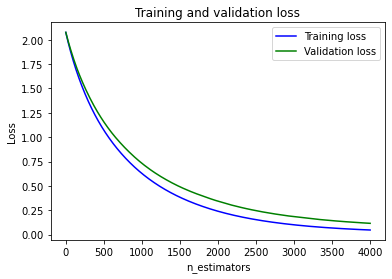

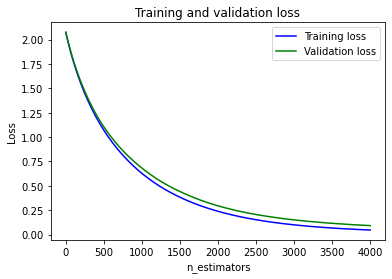

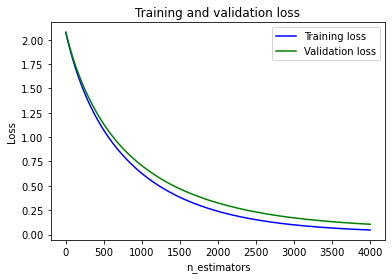

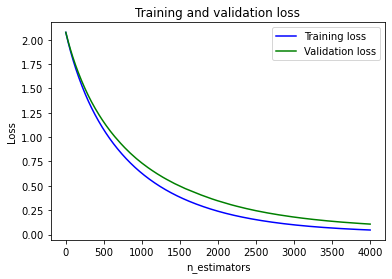

In [37]:
for i in range(4):
    loss = all_history[i].get('validation_0')['mlogloss'] # train
    val_loss = all_history[i].get('validation_1')['mlogloss'] # val
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, 'b', label='Training loss')  # ‘b’는 파란색 실선을 의미합니다.
    plt.plot(epochs, val_loss, 'g', label='Validation loss') # ‘g’는 초록색 실선을 의미합니다.
    plt.title('Training and validation loss')
    plt.xlabel('n_estimators')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [38]:
preds = model.predict(X_test_2dim)

# Result

In [39]:
# rmse
rmse = np.sqrt(mean_squared_error(y_test, preds)) 
print("RMSE: %f" % (rmse))

RMSE: 0.702673


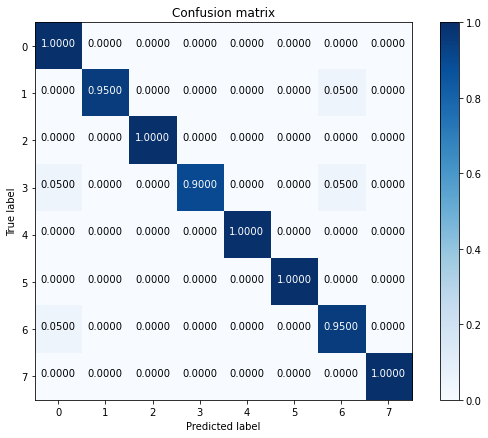

In [40]:
# Confusion Matrix
import itertools
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, preds)
def plot_confusion_matrix(cm, target_names=None, cmap=None, normalize=True, labels=True, title='Confusion matrix'):
    if cmap is None:
        cmap = plt.get_cmap('Blues')

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names)
        plt.yticks(tick_marks, target_names)
    
    if labels:
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            if normalize:
                plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                         horizontalalignment="center",
                         color="white" if cm[i, j] > thresh else "black")
            else:
                plt.text(j, i, "{:,}".format(cm[i, j]),
                         horizontalalignment="center",
                         color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

    
plot_confusion_matrix(cm,[0,1,2,3,4,5,6,7])

In [41]:
cm

array([[20,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 19,  0,  0,  0,  0,  1,  0],
       [ 0,  0, 20,  0,  0,  0,  0,  0],
       [ 1,  0,  0, 18,  0,  0,  1,  0],
       [ 0,  0,  0,  0, 20,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 20,  0,  0],
       [ 1,  0,  0,  0,  0,  0, 19,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 20]])

In [42]:
# label마다의 confusion matrix
from sklearn.metrics import multilabel_confusion_matrix
cm_mat = multilabel_confusion_matrix(y_test, preds)
cm_mat
# TP FN
# FP TN

array([[[138,   2],
        [  0,  20]],

       [[140,   0],
        [  1,  19]],

       [[140,   0],
        [  0,  20]],

       [[140,   0],
        [  2,  18]],

       [[140,   0],
        [  0,  20]],

       [[140,   0],
        [  0,  20]],

       [[138,   2],
        [  1,  19]],

       [[140,   0],
        [  0,  20]]])

In [43]:
# 평가지표 계산
def confusion(cm):
    return cm[0][0], cm[0][1], cm[1][0], cm[1][1]

def accuracy(cm):
    TP, FN, FP, TN = confusion(cm)
    return (TP+TN)/(TP+TN+FP+FN)

def precision(cm):
    TP, FN, FP, TN = confusion(cm)
    return TP/(TP+FP)

def recall(cm):
    TP, FN, FP, TN = confusion(cm)
    return TP/(TP+FN)

def F1(cm):
    return 2*precision(cm)*recall(cm)/(precision(cm)+recall(cm))

In [44]:
# Macro Average 평가지표 계산
accuracy_avg = 0
precision_avg = 0
recall_avg = 0
F1_avg = 0

for i in range(len(cm_mat)):
    accuracy_avg += accuracy(cm_mat[i])
    precision_avg += precision(cm_mat[i])
    recall_avg += recall(cm_mat[i])
    F1_avg += F1(cm_mat[i])

accuracy_avg /= len(cm_mat)
precision_avg /= len(cm_mat)
recall_avg /= len(cm_mat)
F1_avg /= len(cm_mat)

print('accuracy: ', accuracy_avg)
print('precision: ', precision_avg)
print('recall: ', recall_avg)
print('F1: ', F1_avg)

accuracy:  0.99375
precision:  0.9964536312214837
recall:  0.9964285714285714
F1:  0.9964252687226088


## Test

In [45]:
images = glob.glob('./01_finger_test/*.bmp')
len(images)

80

In [46]:
r = re.compile('\d+')

img = [] # 이미지
img_num = [] # 이미지 번호

for fname in images:
    num = r.findall(fname)[1]
    img_num.append(num)
    im = pilimg.open(fname)
    pix = np.array(im)[25:120,25:120]/255. # Normalize
    img.append(pix)

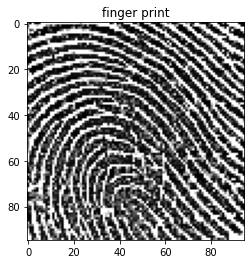

In [47]:
# 지문 이미지
plt.title('finger print')
plt.imshow(X[1], cmap='gray')

In [48]:
X = np.array(img)
X = X.astype('float32')
X = X.reshape(X.shape[0],95,95,1)
X_test_2dim = X.reshape(X.shape[0], 9025)

In [49]:
preds = model.predict(X_test_2dim)
preds_n = np.where(preds==0., 8, preds) # 학습 시 바꿨던 라벨 되돌리기
preds_n

array([6, 3, 7, 5, 2, 2, 8, 3, 2, 7, 5, 2, 6, 3, 7, 6, 1, 6, 5, 1, 6, 2,
       2, 4, 5, 8, 2, 2, 6, 8, 3, 7, 5, 6, 8, 6, 2, 3, 1, 6, 7, 5, 2, 4,
       6, 2, 3, 6, 2, 2, 7, 2, 3, 5, 3, 8, 6, 2, 2, 2, 8, 7, 1, 7, 1, 5,
       2, 8, 7, 3, 2, 3, 5, 6, 6, 2, 6, 4, 8, 8], dtype=int32)

In [50]:
import pandas as pd
res_df = pd.DataFrame(img_num, columns=['Image'], dtype='int32')
res_df['Answer'] = pd.Series(preds_n, dtype='int32')
res_df.sort_values(by=['Image'], axis=0, inplace=True)
res_df

,Image,Answer
2,1,7
5,2,2
42,3,2
33,4,6
38,5,1
...,...,...
64,76,1
61,77,7
19,78,1
31,79,7


In [51]:
res_df['Answer'].value_counts()

2    20
6    15
3    10
5     9
7     9
8     9
1     5
4     3
Name: Answer, dtype: int64

In [60]:
res_df.to_csv('./1871085_지문_1차_답안.csv', index=False)